# Notebook Context

This is 5 of 6 Jupyter Notebooks associated with the used car project.

This covers:
* The initial model selection where many models are evaluated quickly on a subset of the data to assess which modelling avenues should be pursued.
* The full-fidelity modelling on the entire dataset, using the two most promising models from the initial stage.

Besides the Python code involved in each of these steps, I've tried to add a text narrative either through markdown, comments or both. I know that this notebook isn't as finely polished as I'd like it to be but it should be very possible to follow my thought process at each stage.

Data input to this notebook are cleaned, merged and generally prepared in notebook [04_Data_cleaning_and_EDA](https://github.com/rgdavies92/used-car-value/blob/main/04_Data_cleaning_and_EDA.ipynb).

# Executive Summary


<b>1. Project Goals</b>
* Generate a predictive model for used car price in the UK in 2022.
    * The final model must be interpretable.
* Test the hypothesis that when all other car features are equal, a Dacia branded car is cheaper than a Volvo branded car. 
    * Learn what the model can tell us about car brands.


<b>2. Metrics Utilised</b>
* The main metric used will be R<sup>2</sup>-score, which is the amount of unexplained variance above the baseline which can be explained by the model. 
* Supplementary metrics of Root Mean Squared Error (RMSE) and Mean Squared Error (MSE) will be used to further evaluate models. 

<b>3. Results</b>
* A comprehensive used car dataset was scraped from autotrader.co.uk, holding 374,000 used cars appropriate for modelling.
* Base versions of 10 different models were evaluated and ranked using a 50,000 row subset of the used car dataset. Two models - LinearRegression() and GradientBoostingRegression() were then selected for further model optimisation on the full dataset and subsequent model evaluation. 
    * Final LinearRegression() R2 score on the price target was 0.881. 
    * <b>Final GradientBoostingRegression() R2 score on the price target was 0.953</b>. 
    * Both models proved to generalise well, with test and train R2 scores within 0.003.
    * Of the top 10 predictors/features for each model, 6 of them were predictors/features in common.
* ELI5 permutation importance feature has been used to explain and interpret granular detail contained within the GradientBoostingRegression() model which is not evident from the standard gini-based feature importance. 
* Dummy cars were fed into the GradientBoostingRegression() model and analysed with ELI5 to confirm that <b>a Dacia branded car is indeed cheaper than a Volvo branded car</b>.
* No strong evidence has been found to suggest that car sale location impacts sale price, although further work is recommended.
    
<b>4. Risks/limitations/assumptions</b>
* All used car data were gathered over two weeks between January and February 2022. At this moment the second hand car market is artificially inflated due to 'ongoing chip shortages'. As such, the accuracy of all conclusions and insights will fall with time as market conditions change. 
* Outlier analysis has revealed some data-entry mistakes on autotrader.co.uk. Data-entry mistakes which can be observed as statistical anomalies have been removed from the dataset however this by no means confirms that others don't remain.
* When buying a new car there are often a number of tiers to choose from in terms of 'car spec'. Although some engine attributes may be incorporated in the 'BHP' statistic, much of this information is not captured at a used car sale and is not accounted for in this project. For example there is no information on whether a used car has a leather interior with rear view cameras and parking sensors.
* Car size variables could be obtained more accurately. At this stage they have been scraped from carsized.com.

In [1]:
# Import modelling libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score 
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
import eli5
import xgboost
from xgboost import XGBRegressor
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# Model selection on 50,000 used cars

First of all, I evaluate a range of models on a random subset of 50,000 rows from the used cars data. This allows for a quick evaluation of model suitability.

* Outliers from the used car dataset are removed from the normally distributed log-price target variable.
* Car makes/brands with < 50 cars within the subset are dropped to ensure robust predictions.
* Columns used for modelling are `price`/`log_price`, `mileage`/`log_mileage`, `BHP`, `year`, `drivetrain`, `make`, `body`, `transmission`, `fuel` and `doors`. 
    * `price`/`log_price`, `mileage`/`log_mileage`, `BHP` and `year` are continuous.
    * `drivetrain`, `make`, `body`, `transmission`, `fuel` and `doors` are one-hot encoded.
    * `log_price` and `log_mileage` are used for linear regression models, whilst `price` and `log-mileage` are used for tree-based models. Note that I could have used simple mileage for the tree based models but honestly I forgot to change it back. It makes no difference to decision tree models so I left it. 
    * Standard scaling is applied to predictors for the linear regression models whilst no scaling is applied for the tree-based models.
* Models tested are:
    * Linear Regression
    * Linear Regression with L1 regularization
    * Linear Regression with L2 regularization
    * Linear Regression with Elastic Net regularization
    * Decision Tree Regression
    * Random Forest Regression
    * Gradient Boosting Regression
    * Ada Boosting Regression with a Decision Tree base model
    * Extreme Gradient Boosting Regression
* Each model is evaluated by mean R<sup>2</sup> score after 5-fold cross validation on the training set as well as R<sup>2</sup> score on the test set.
* Residuals are described using Root Mean Squared Error (RMSE) and Mean Squared Error (MSE).
    

In [2]:
# Read clean used cars data from Notebook 04_Data_Cleaning_and_EDA

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
df = pd.read_csv(abspath)
print('all',df.shape)

df = df[df['used']==1]
print('used',df.shape)

# Drop outliers in log-price greater than three standard deviations from the mean
mask = np.abs((df.log_price - df.log_price.mean())) / df.log_price.std() > 3
df= df[~mask]
print('used_without_outliers',df.shape)

all (400245, 28)
used (378595, 28)
used_without_outliers (374504, 28)


In [3]:
# Drop columns not useful in modelling as defined in Notebook 04_Data_Cleaning_and_EDA

df = df.drop(labels=['name','name_subtitle','link','seller1',
                     'href0','dealer_city','dealer_area','year_reg',
                     'orig_name','e_engine_kWh','ULEZ','id','used','owners','engine','mpg'], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374504 entries, 0 to 400244
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          374504 non-null  int64  
 1   price         374504 non-null  float64
 2   body          374504 non-null  object 
 3   mileage       374504 non-null  float64
 4   BHP           374504 non-null  float64
 5   doors         374504 non-null  object 
 6   transmission  374504 non-null  object 
 7   make          374504 non-null  object 
 8   fuel          374504 non-null  object 
 9   drivertrain   374504 non-null  object 
 10  log_price     374504 non-null  float64
 11  log_mileage   374504 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 37.1+ MB


In [5]:
# Drop car makes which have less than 50 cars in the model evaluation subset
# This is done to prevent the model interpreting a small number of data points as statistically significant
dfsample = df.sample(50000, random_state=1)
carnums = dfsample.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>50].make.to_list()
dfsample = dfsample[dfsample.make.isin(carmakes)]

In [6]:
dfsample.shape

(49777, 12)

Before I dive head first into each of the models tested for this project, I'd like to provide a general overview of how it's been done, with a short comment on the assumptions, advantages and disadvantages of each method. 

9 models have been tested, and they've been described in a sort of model family tree below. 
* On a high level they can be divided into linear method and tree based methods. 
* Beyond this I have further divided them into regularisation, ensemble, bagging and boosting methods. I’m not trying to imply that this is the only possibly way to utilise these modelling methods, only expressing that this is how it has been tested for this project.  


<img src="images/modelselection1.png" style="width: 700px;"/>


**Linear Methods**
* Assumptions
    * Linearity - all relationships between target and predictor variables are linear.
    * Normality - that the target variable follows a normal distribution.
    * Homoscedasticity - error terms are constant over the entire feature space.
    * Independence - all instances are independent of any other instance.
    * Fixed features - variables can all be treated as constants, without any error bounds.
    * Absence of multicollinearity - predictor variables are not strongly related to each other.


* Advantages
    * Ultimate transparency in terms of how predictions are produced.
    * Commonly used and well understood - easy to explain to stakeholders.
    * Mathematically straight forward. It is possible to find optimal weights for all predictors.


* Disadvantages
    * Assumptions can be strict and unrealistic. Model performance will suffer if they are not met.
    * For any non-linear relationship, a custom made non-linear variable would have to be hand crafted and explicitly given to the model as an input feature.
    * Often over-simplifies how complex the real situation is to a linear relationship.
    * Interpretation of a weight can sometimes be counter-intuitive due to interactions with other features and complications with multicollinearity. 
    
<br>
<br>

**Tree Based Methods**
* Assumptions
    * None! A decision tree will prefer categorical predictors, but in the case on continuous predictors it simply discretises them prior to model building.
* Advantages
    * If there is a non-linear and complex relationship between target and predictors, a decision tree will outperform a linear regression method.
    * The tree structure has a very natural visualisation, with nodes and edges.
    * There is no need to transform features. In linear models, it is sometimes necessary to take the logarithm of a feature. A decision tree works equally well with any monotonic transformation of a feature.
* Disadvantages
    * Trees struggle to deal with linear relationships. Any linear relationship between an input feature and the outcome has to be approximated by splits, creating a step function. This is not efficient. This goes hand in hand with a lack of smoothness.
    * As decision trees grow in number of branches, they become far harder to interpret.
    

At this point I'm also going to highlight the difference in workflows for each of the linear and tree based methods.

<br>
<br>
<b>Standardisation</b>

For linear methods, standard scaling is applied to the predictor variables, manipulating them to be of a comparable magnitude before input to modelling. For every predictor the mean value is subtracted from each value before dividing by the standard deviation. This allows for the influence of all predictors to be interpreted equally without influence from magnitude.

Note that Standard scaling is only applied for the linear regression based models. Scaling is not required for decision tree based models.

<br>
<br>
<b> Grid Searching for model parameters</b>

A simple grid search over a subset of some of the modelling parameters has been implemented for each model. Note that these are not the finalised models still, just a proof of concept for each of the methods to provide some quick feedback. 

<br>
<br>
<b>Cross Validation</b>

Cross validation will be carried out using both train_test_split and the CV component within GridSearchCV. The is to ensure that any produced models generalise well and do not over-fit the data.
* For train_test_split I employ a 80/20 train/test split. I also shuffle the target variable and use a random_state to ensure that each model being tested uses the same input data.
* Using a cv parameter of 5 within the GridSearchCV tool for each model build ensures that the optimal model parameters are validated by a 5-fold cross validation before being recommended. This again works to prevent over-fitting of data.

<br>
<br>
<b>Model Scoring</b>

In order to meet linear regression assumptions, some continuous variables within the modelling process have been log transformed to obtain a normal distribution. As such, the target variable for linear regression models is `log_price` rather than `price`. In order to attain comparability between linear regression models and decision tree models (which have no log-transform required), all model scoring attributes have been computed on the price variable rather than the `log_price` variable. This involves a small amount of logarithmic gymnastics around model scoring metric for the linear methods, but it has been easy enough to implement. With that said, this is just another reason that I prefer working with the decision tree methods in this case.

* R<sup>2</sup> score will be the primary metric by which models are evaluated. The R<sup>2</sup> score represents the fraction of unexplained variance above the baseline which can be explained by the model.
* RMSE (or RMSD) represents the quadratic mean of the difference between predicted values and true values. It is the square root of the average of squared errors. The effect of each error on RMSE is proportional to the size of the squared error - thus larger errors have disproportionately large effect on RMSE! RMSE has the same units as the quantity being estimated. 
* MSE represents the average squared difference between predicted values and true values. It is the average of the squares of errors. MSE is described in square units of the quantity being estimated. 



<img src="images/modelselection2.png" style="width: 500px;"/>


## LinearRegression()

Why might I look to use a linear regression model?

Having taken a log of the target variable (price) and the mileage predictor there now appears to be a number of (sort of) linear relationships between the continuous predictors in the dataset (see Pairplot below). Although it comes loaded with assumptions, linear regression can be one of the most simple ML models to understand and so is a nice place to start. 

Linear regression within Sklearn implements an ordinary least squares regression, which works to minimise the residual sum of squares (RSS) to best fit the data. i.e. RSS is the loss function for linear regression.

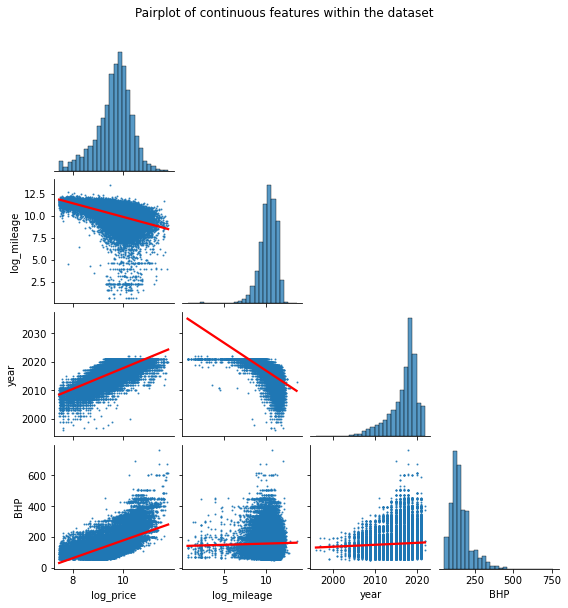

In [7]:
# Pairplot of continuous features within the 50,000 car random sample
g = sns.pairplot(dfsample[['log_price','log_mileage','year','BHP']], kind="reg", corner=True, height=2,
                 plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'s':1}},
                 grid_kws={'diag_sharey':False}, 
                 diag_kws={'bins':26});
g.fig.suptitle("Pairplot of continuous features within the dataset", y=1.05)
plt.show()

I had already alluded to it in notebook 04_Data_Cleaning_and_EDA, but some of these relationships are not perfectly linear. As such, I can expect linear regression methods to be compromised somewhat. The model selection continues to test these methods anyway for completeness.

In [8]:
# Preparing train and test datasets for the linear methods.

# Subset dfsample to obtain X
X = dfsample[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
# Pop target variable - in this case it's the log_price
y = X.pop('log_price')
# Dummify necessary columns 
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y, random_state=2)

Dummified df shape (49777, 60) 



In [9]:
# Modelling with dummies - SKLEARN LinearRegression() 

# Linear methods require variables to be of similar magnitude so we use standard scalar in the pipeline
scaler = StandardScaler()
lr = LinearRegression()
pipelr = Pipeline(steps=[('scaler',scaler),('model',lr)])

params = {'model__copy_X': [True],
          'model__fit_intercept': [True],
          'model__n_jobs': [2],
          'model__normalize': [False],
          'model__positive': [False]}

gridsearchlr = GridSearchCV(pipelr, params, cv=5, verbose=1)
gridsearchlr.fit(X_train, y_train)

# LinearRegression Model evaluation stats - converted back to price rather than log-price
train_preds = gridsearchlr.predict(X_train)
test_preds = gridsearchlr.predict(X_test)
printmd('**LINEAR REGRESSION**')
print('MSE train:',mean_squared_error(np.exp(y_train), np.exp(train_preds)))
print('MSE test:',mean_squared_error(np.exp(y_test), np.exp(test_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_train), np.exp(train_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_test), np.exp(test_preds)))))
print('R2 train on log_price:',gridsearchlr.score(X_train, y_train))
print('R2 test on log_price:',gridsearchlr.score(X_test, y_test))
print('R2 train on price:',r2_score(np.exp(y_train), np.exp(train_preds)))
print('R2 test on price:',r2_score(np.exp(y_test), np.exp(test_preds)))
print('\n')
print(gridsearchlr.best_estimator_)

# Save stats for summary later
lrdict = {'Model': 'Linear Regression', 
          'MSE Train': mean_squared_error(np.exp(y_train), np.exp(train_preds)),
          'MSE Test': mean_squared_error(np.exp(y_test), np.exp(test_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(train_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(test_preds))),
          'R2 Train': r2_score(np.exp(y_train), np.exp(train_preds)),
          'R2 Test': r2_score(np.exp(y_test), np.exp(test_preds)),
          'Params': gridsearchlr.best_estimator_
         }

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**LINEAR REGRESSION**

MSE train: 17999211.0349018
MSE test: 18670388.451415297
RMSE train: 4242.547705671888
RMSE test: 4320.9244903626
R2 train on log_price: 0.9152230846794147
R2 test on log_price: 0.9110485605149862
R2 train on price: 0.8731563226038671
R2 test on price: 0.8729398361639004


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearRegression(n_jobs=2))])


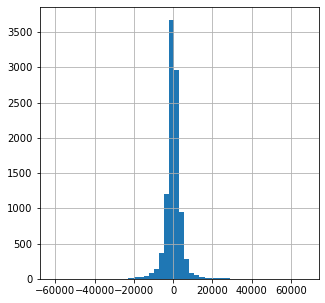

In [10]:
# Plot residuals as a sanity check
lr_resid_50 = np.exp(y_test) - np.exp(test_preds)
lr_resid_50.hist(bins=50, figsize=(5,5));

## Lasso()

Why might I look to use a Lasso regression model? Or a linear regression with L1 penalisation added to the loss function.

This builds on the RSS loss function in ordinary least squares regression by using the the RSS plus the sum of absolute values of all beta coefficients as the Lasso loss function. This form of regularisation can be useful as a form of feature selection when you have many predictors. 

In [11]:
# Modelling with dummies - SKLEARN Lasso()

# Using train and test data from before 

# Linear methods require variables to be of similar magnitude so we use standard scalar in the pipeline
scaler = StandardScaler()
la = Lasso()
pipela = Pipeline(steps=[('scaler',scaler),('model',la)])
pipela.get_params()

params = {'model__alpha': [0.0001],
         'model__max_iter': [2000],
         'model__tol': [0.001]}

gridsearchla= GridSearchCV(pipela, params, cv=5, verbose=1)
gridsearchla.fit(X_train, y_train)

# Lasso Model evaluation stats - converted back to price rather than log-price
train_preds = gridsearchla.predict(X_train)
test_preds = gridsearchla.predict(X_test)
printmd('**LASSO**')
print('MSE train:',mean_squared_error(np.exp(y_train), np.exp(train_preds)))
print('MSE test:',mean_squared_error(np.exp(y_test), np.exp(test_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_train), np.exp(train_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_test), np.exp(test_preds)))))
print('R2 train on log_price:',gridsearchla.score(X_train, y_train))
print('R2 test on log_price:',gridsearchla.score(X_test, y_test))
print('R2 train on price:',r2_score(np.exp(y_train), np.exp(train_preds)))
print('R2 test on price:',r2_score(np.exp(y_test), np.exp(test_preds)))
print('\n')
print(gridsearchla.best_estimator_)

# Save stats for summary later
ladict = {'Model': 'Lasso (L1) Regression', 
          'MSE Train': mean_squared_error(np.exp(y_train), np.exp(train_preds)),
          'MSE Test': mean_squared_error(np.exp(y_test), np.exp(test_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(train_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(test_preds))), 
          'R2 Train': r2_score(np.exp(y_train), np.exp(train_preds)),
          'R2 Test': r2_score(np.exp(y_test), np.exp(test_preds)),
          'Params': gridsearchla.best_estimator_,
         }

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**LASSO**

MSE train: 17963472.31764859
MSE test: 18627884.296439826
RMSE train: 4238.3336722878
RMSE test: 4316.003278084926
R2 train on log_price: 0.9152130906914714
R2 test on log_price: 0.9110742062107353
R2 train on price: 0.8734081797721078
R2 test on price: 0.8732290955389237


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=0.0001, max_iter=2000, tol=0.001))])


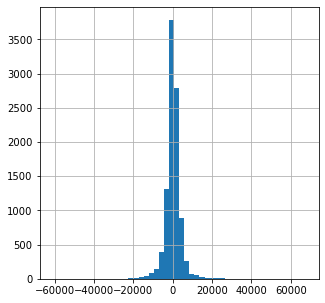

In [12]:
# Plot residuals as a sanity check
la_resid_50 = np.exp(y_test) - np.exp(test_preds)
la_resid_50.hist(bins=50, figsize=(5,5));

## Ridge()

Why might I look to use a Ridge regression model? Or a linear regression with L2 penalisation added to the loss function.

This builds on the RSS loss function in ordinary least squares regression by using the the RSS plus some regularisation constant (Lambda usually) times the sum of squares of all beta coefficients as the Ridge loss function. This form of regularisation can be useful when you have multi-collinnearity within the dataset.

In [13]:
# Modelling with dummies - SKLEARN Ridge()

# Using train and test data from before 

# Linear methods require variables to be of similar magnitude so we use standard scalar in the pipeline
scaler = StandardScaler()
rr = Ridge()
piperr = Pipeline(steps=[('scaler',scaler),('model',rr)])
piperr.get_params()

params = {'model__alpha': [0.5,1,5,50,5000],
         'model__max_iter': [200],
         'model__solver': ['auto'],
         'model__tol': [0.001]}

gridsearchrr = GridSearchCV(piperr, params, cv=5, verbose=1)
gridsearchrr.fit(X_train, y_train)

# RIDGE Model evaluation stats - converted back to price rather than log-price
train_preds = gridsearchrr.predict(X_train)
test_preds = gridsearchrr.predict(X_test)
printmd('**RIDGE**')
print('MSE train:',mean_squared_error(np.exp(y_train), np.exp(train_preds)))
print('MSE test:',mean_squared_error(np.exp(y_test), np.exp(test_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_train), np.exp(train_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_test), np.exp(test_preds)))))
print('R2 train on log_price:',gridsearchrr.score(X_train, y_train))
print('R2 test on log_price:',gridsearchrr.score(X_test, y_test))
print('R2 train on price:',r2_score(np.exp(y_train), np.exp(train_preds)))
print('R2 test on price:',r2_score(np.exp(y_test), np.exp(test_preds)))
print('\n')
print(gridsearchrr.best_estimator_)

# Save stats for summary later
rrdict = {'Model': 'Ridge (L2) Regression', 
          'MSE Train': mean_squared_error(np.exp(y_train), np.exp(train_preds)),
          'MSE Test': mean_squared_error(np.exp(y_test), np.exp(test_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(train_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(test_preds))), 
          'R2 Train': r2_score(np.exp(y_train), np.exp(train_preds)),
          'R2 Test': r2_score(np.exp(y_test), np.exp(test_preds)),
          'Params': gridsearchrr.best_estimator_
         }

Fitting 5 folds for each of 5 candidates, totalling 25 fits


**RIDGE**

MSE train: 17995717.343221165
MSE test: 18667457.328751937
RMSE train: 4242.135941152896
RMSE test: 4320.585299326
R2 train on log_price: 0.9152228405984022
R2 test on log_price: 0.9110503397224435
R2 train on price: 0.8731809432774955
R2 test on price: 0.872959783736325


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Ridge(alpha=5, max_iter=200))])


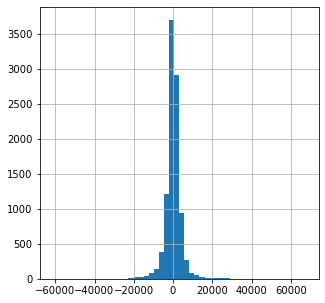

In [14]:
# Plot residuals as a sanity check
rr_resid_50 = np.exp(y_test) - np.exp(test_preds)
rr_resid_50.hist(bins=50, figsize=(5,5));

## ElasticNet() 

Why might I look to use a Elastic Net regression model? Or a linear regression with both L1 and L2 penalisation added to the loss function.

This can combine the best of both worlds. Where the optimum regressor is neither ridge nor lasso, this can blend the two loss functions to find the sweet spot in the middle.  


In [15]:
# Modelling with dummies - SKLEARN ElasticNet()

# Using train and test data from before 

# Linear methods require variables to be of similar magnitude so we use standard scalar in the pipeline
scaler = StandardScaler()
en = ElasticNet()
pipeen = Pipeline(steps=[('scaler',scaler),('model',en)])
pipeen.get_params()

params = {'model__alpha': [0.0001], 
          'model__l1_ratio': [0.5],
          'model__max_iter': [1000, 2000],
          'model__random_state': [1],
          'model__tol': [0.01]}

gridsearchen = GridSearchCV(pipeen, params, cv=5, verbose=0)
gridsearchen.fit(X_train, y_train)

# ELASTIC NET Model evaluation stats - converted back to price rather than log-price
train_preds = gridsearchen.predict(X_train)
test_preds = gridsearchen.predict(X_test)
printmd('**ELASTIC NET**')
print('MSE train:',mean_squared_error(np.exp(y_train), np.exp(train_preds)))
print('MSE test:',mean_squared_error(np.exp(y_test), np.exp(test_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_train), np.exp(train_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_test), np.exp(test_preds)))))
print('R2 train on log_price:',gridsearchen.score(X_train, y_train))
print('R2 test on log_price:',gridsearchen.score(X_test, y_test))
print('R2 train on price:',r2_score(np.exp(y_train), np.exp(train_preds)))
print('R2 test on price:',r2_score(np.exp(y_test), np.exp(test_preds)))
print('\n')
print(gridsearchen.best_estimator_)

# Save stats for summary later
eldict = {'Model': 'Elastic Net Regression', 
          'MSE Train': mean_squared_error(np.exp(y_train), np.exp(train_preds)),
          'MSE Test': mean_squared_error(np.exp(y_test), np.exp(test_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(train_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(test_preds))),
          'R2 Train': r2_score(np.exp(y_train), np.exp(train_preds)),
          'R2 Test': r2_score(np.exp(y_test), np.exp(test_preds)),
          'Params': gridsearchen.best_estimator_
         }

**ELASTIC NET**

MSE train: 17975964.29026151
MSE test: 18644843.841669902
RMSE train: 4239.8071053128715
RMSE test: 4317.9675591266205
R2 train on log_price: 0.915215476698098
R2 test on log_price: 0.911065146323224
R2 train on price: 0.8733201465943712
R2 test on price: 0.8731136784118978


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', ElasticNet(alpha=0.0001, random_state=1, tol=0.01))])


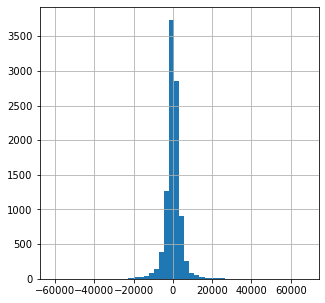

In [16]:
# Plot residuals
en_resid_50 = np.exp(y_test) - np.exp(test_preds)
en_resid_50.hist(bins=50, figsize=(5,5));

All linear based models, with or without regularisation yield an R<sup>2</sup> score of 0.87. Since the L1 and L2 regularisation yielded very similar reulsts I didn't bother to extensively search for optimum Elastic Net parameters. 

The LinearRegression() model is a good place to start, but hopefully it can be improved. Next we move onto tree based methods.

## DecisionTreeRegressor()

Why might I look to use a decision tree regression model?

Where linear regression methods have a number of restrictive conditions on when they can be used, decision tree methods have none! Linear regression and logistic regression models fail in situations where the relationship between features and outcome is nonlinear or where features interact with each other. Time to shine for the decision tree! Tree based models split the data multiple times according to certain cutoff values in the features. Through splitting, different subsets of the dataset are created, with each instance belonging to one subset. The final subsets are called terminal or leaf nodes and the intermediate subsets are called internal nodes or split nodes. To predict the outcome in each leaf node, the average outcome of the training data in this node is used.

In [17]:
# Preparing train and test datasets for the tree based methods. In this case it doesn't matter if the target
# variable is normally distributed or not, so I just use price and mileage instead of log_price and log_mileage. 

# Subset dfsample to obtain X
X = dfsample[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
# Pop target variable - in this case it's the price
y = X.pop('price')
# Dummify necessary columns 
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y, random_state=1)

Dummified df shape (49777, 60) 



Plain old decision tress such as this one have the problem of over-fitting the data very very easily. To combat this in this instance, I have implemented the max_depth, max_leaf_nodes and min_sample_leaf parameters. I know that if I were to remove these limits I could easily reach a 0.99 R<sup>2</sup> score on the train dataset, but then it likely wouldn't perform as well on the test dataset.

In [18]:
# Modelling with dummies - SKLEARN DecisionTreeRegressor() 

# Decision tree methods don't require the predictord variables to be standardised, so I haven't! This workflow is 
# different to the linear models. It makes the pipeline look a little redundant but I've kept it in out of 
# consistency
dt = DecisionTreeRegressor()
pipedt = Pipeline(steps=[('model',dt)])
pipedt.get_params()

# Parameters to grid search over. 
params = {'model__criterion': ['mse', 'friedman_mse', 'poisson'],
         'model__max_depth': [15,50,100],
         'model__max_leaf_nodes': [500,1000,2000],
         'model__min_samples_leaf': [25,50,100],
         'model__splitter': ['best']}

gridsearchdt = GridSearchCV(pipedt, params, cv=5, verbose=1)
gridsearchdt.fit(X_train, y_train)

# DECISION TREE evaluation stats
train_preds = gridsearchdt.predict(X_train)
test_preds = gridsearchdt.predict(X_test)
printmd('**DECISION TREE REGRESSOR**')
print('MSE train:',mean_squared_error(y_train, train_preds))
print('MSE test:',mean_squared_error(y_test, test_preds))
print('RMSE train:',np.sqrt((mean_squared_error(y_train, train_preds))))
print('RMSE test:',np.sqrt((mean_squared_error(y_test, test_preds))))
print('R2 train:',gridsearchdt.score(X_train, y_train))
print('R2 test:',gridsearchdt.score(X_test, y_test))
print('\n')
print(gridsearchdt.best_estimator_)

# Save stats for summary later
dtdict = {'Model': 'Decision Tree Regressor', 
          'MSE Train': mean_squared_error(y_train, train_preds),
          'MSE Test': mean_squared_error(y_test, test_preds),
          'RMSE Train': np.sqrt(mean_squared_error(y_train, train_preds)),
          'RMSE Test': np.sqrt(mean_squared_error(y_test, test_preds)),
          'R2 Train': gridsearchdt.score(X_train, y_train),
          'R2 Test': gridsearchdt.score(X_test, y_test),
          'Params': gridsearchdt.best_estimator_
         }

Fitting 5 folds for each of 81 candidates, totalling 405 fits


**DECISION TREE REGRESSOR**

MSE train: 11159314.120068192
MSE test: 13370887.9639525
RMSE train: 3340.555959727092
RMSE test: 3656.6224803707178
R2 train: 0.921888826130185
R2 test: 0.9066017490190144


Pipeline(steps=[('model',
                 DecisionTreeRegressor(criterion='friedman_mse', max_depth=50,
                                       max_leaf_nodes=1000,
                                       min_samples_leaf=25))])


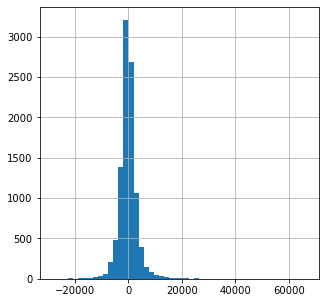

In [19]:
# Plot residuals as a sanity check
dt_resid_50 = y_test - test_preds
dt_resid_50.hist(bins=50, figsize=(5,5));

## RandomForestRegressor()

Why might I look to use a Random Forest regression model?

Random Forests consist of many decision trees - it's a bagging ensemble method. Each decision tree is built using a random subset of observations and predictors to generate the tree. Variability of the trees is introduced in this way. To obtain a prediction for a given observation(car) the observation is run through each of the individual trees in the forest and the final result from all trees is averaged. The sheer number of trees and the randomness involved in generating each one makes results more difficult to interpret than a single decision tree. 

In [20]:
# Modelling with dummies - SKLEARN RandomForestRegressor()) 

rf = RandomForestRegressor()
piperf = Pipeline(steps=[('model',rf)])
piperf.get_params()

# Random forest paraneters to search over. Note that the optimium parameters are printed out below.
params = {'model__max_depth': [3,5,8,15],
          'model__n_estimators': [50,100,200],
          'model__n_jobs': [3],
          'model__max_features': [0.3, 0.5, 'auto']}

gridsearchrf = GridSearchCV(piperf, params, cv=5, verbose=1)
gridsearchrf.fit(X_train, y_train)

# SKLEARN Random Forest Model evaluation stats
train_preds = gridsearchrf.predict(X_train)
test_preds = gridsearchrf.predict(X_test)
printmd('**RANDOM FOREST REGRESSOR**')
print('MSE train:',mean_squared_error(y_train, train_preds))
print('MSE test:',mean_squared_error(y_test, test_preds))
print('RMSE train:',np.sqrt(mean_squared_error(y_train, train_preds)))
print('RMSE test:',np.sqrt(mean_squared_error(y_test, test_preds)))
print('R2 train:',gridsearchrf.score(X_train, y_train))
print('R2 test:',gridsearchrf.score(X_test, y_test))
print('\n')
print(gridsearchrf.best_estimator_)

# Save stats for summary later
rfdict = {'Model': 'Random Forrest Regressor', 
          'MSE Train': mean_squared_error(y_train, train_preds),
          'MSE Test': mean_squared_error(y_test, test_preds), 
          'RMSE Train': np.sqrt(mean_squared_error(y_train, train_preds)),
          'RMSE Test': np.sqrt(mean_squared_error(y_test, test_preds)), 
          'R2 Train': gridsearchrf.score(X_train, y_train),
          'R2 Test': gridsearchrf.score(X_test, y_test),
          'Params': gridsearchrf.best_estimator_
         }

Fitting 5 folds for each of 36 candidates, totalling 180 fits


**RANDOM FOREST REGRESSOR**

MSE train: 2991234.89403683
MSE test: 7059899.493318034
RMSE train: 1729.5186885480105
RMSE test: 2657.047137955598
R2 train: 0.979062434628183
R2 test: 0.9506852299895769


Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=15, max_features=0.5,
                                       n_estimators=200, n_jobs=3))])


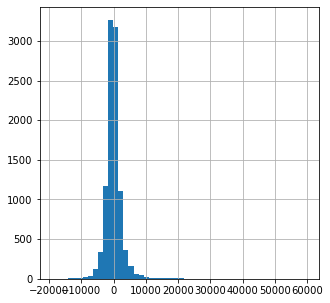

In [21]:
# Plot residuals as a sanity check
rf_resid_50 = y_test - test_preds
rf_resid_50.hist(bins=50, figsize=(5,5));

## AdaBoostRegressor()

Why might I look to use an Adaptive Boosting regression model?

First of all, AdaBoost is a boosting ensemble method. It produces a large number of weak learners with a sequential method. These are called stumps because they are decision trees with a single split. It uses a defined learning rate at each step to add more weight to the difficult observations to model and reduce weight on the ones which are already modelled well. This learning rate ensures that many small steps are taken in the model progression. New weak learners (stumps) are added sequentially to focus the training on more the difficult patterns within the data.

In [22]:
# Modelling with dummies - SKLEARN AdaBoostRegressor()) 

modelab = AdaBoostRegressor()
pipeab = Pipeline(steps=[('model',modelab)])
pipeab.get_params()

# I make a stumpy decision tree as my base estimator here. 
dt_stump = DecisionTreeRegressor()
pipedt_stump = Pipeline(steps=[('model',dt_stump)])
params_stump = {'model__criterion': ['mse', 'friedman_mse', 'poisson'],
         'model__max_depth': [2],
         'model__splitter': ['best']}
gridsearchdt_stump = GridSearchCV(pipedt_stump, params_stump, cv=5, verbose=1)
gridsearchdt_stump.fit(X_train, y_train)


params = {'model__base_estimator':[gridsearchdt_stump.best_estimator_.named_steps["model"]],
          'model__n_estimators':[50,100,200,400],
          'model__learning_rate':[0.1,0.3,0.5],
          'model__loss':['linear', 'square', 'exponential'],
          'model__random_state':[1]}

gridsearchab = GridSearchCV(pipeab, params, cv=5, verbose=1)
gridsearchab.fit(X_train, y_train)

# SKLEARN AdaBoosting Model evaluation stats
train_preds = gridsearchab.predict(X_train)
test_preds = gridsearchab.predict(X_test)
printmd('**ADA BOOST**')
print('MSE train:',mean_squared_error(y_train, train_preds))
print('MSE test:',mean_squared_error(y_test, test_preds))
print('RMSE train:',np.sqrt(mean_squared_error(y_train, train_preds)))
print('RMSE test:',np.sqrt(mean_squared_error(y_test, test_preds)))
print('R2 train:',gridsearchab.score(X_train, y_train))
print('R2 test:',gridsearchab.score(X_test, y_test))
print(gridsearchab.best_estimator_)

# Save stats for summary later
abdict = {'Model': 'Ada Boosting Regressor', 
          'MSE Train': mean_squared_error(y_train, train_preds),
          'MSE Test': mean_squared_error(y_test, test_preds),
          'RMSE Train': np.sqrt(mean_squared_error(y_train, train_preds)),
          'RMSE Test': np.sqrt(mean_squared_error(y_test, test_preds)),
          'R2 Train': gridsearchab.score(X_train, y_train),
          'R2 Test': gridsearchab.score(X_test, y_test),
          'Params': gridsearchab.best_estimator_
         }

Fitting 5 folds for each of 36 candidates, totalling 180 fits


**ADA BOOST**

MSE train: 4085892.601358104
MSE test: 8381160.442657121
RMSE train: 2021.3590975771979
RMSE test: 2895.0233924196746
R2 train: 0.9714002255009447
R2 test: 0.941455965479214
Pipeline(steps=[('model',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                                        max_depth=50,
                                                                        max_leaf_nodes=1000,
                                                                        min_samples_leaf=25),
                                   learning_rate=0.3, n_estimators=100,
                                   random_state=1))])


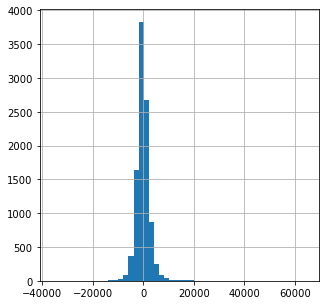

In [23]:
# Plot residuals as a sanity check
ab_resid_50 = y_test - test_preds
ab_resid_50.hist(bins=50, figsize=(5,5));

## GradientBoostingRegressor()

Why might I look to use a Gradient Boosting regression model?

Gradient Boosting is a generalisation of adaptive boosting. It is also a boosting ensemble method. Similarly to AdaBoosting, a series of weak learners are iteratively produced and added to the ensemble model, however this time each weak is larger than a single branch or stump. Gradient Boosting works by first of all predicting the average value for all observations and defining a loss function to be optimised/minimised at each successive step, then weak learners are created to reduce the loss function at each step. After each step the new weak learner is added to the ensemble and the loss function re-evaluated before starting the process again. The model is considered to have converged when progressive steps fail to reduce the loss function.
<br>
<br>
Alternatively, here is my description from a non-technical summary:
* Gradient boosting starts with a base prediction by adopting the average value for the target variable before generating sequential predictors which aim to minimise the residuals between the base prediction and the actual values. 
* Each sequential predictor is scaled by a 'learning factor' before being added to the ensemble. This is usually some small fraction like 0.1 which forces the gradient boosting ensemble model to iteratively take small steps towards a better model with minimised residuals. 
* Taking many small steps in the right direction results in better predictions with a testing dataset. i.e. lower variance. 
* The model is considered optimised when adding new scaled predictors to the ensemble fails to reduce the residual

In [24]:
# Modelling with dummies - SKLEARN GradientBoostingRegressor()) 

model = GradientBoostingRegressor()
pipegb = Pipeline(steps=[('model',model)])
pipegb.get_params()

params = {'model__n_estimators':[100,200],
          'model__max_depth':[3,5,8],
          'model__learning_rate':[0.05,0.1,0.2],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb = GridSearchCV(pipegb, params, cv=5, verbose=1)
gridsearchgb.fit(X_train, y_train)

# SKLEARN Gradient Boosting Model evaluation stats
train_preds = gridsearchgb.predict(X_train)
test_preds = gridsearchgb.predict(X_test)
printmd('**GRADIENT BOOSTING REGRESSOR**')
print('MSE train:',mean_squared_error(y_train, train_preds))
print('MSE test:',mean_squared_error(y_test, test_preds))
print('RMSE train:',np.sqrt(mean_squared_error(y_train, train_preds)))
print('RMSE test:',np.sqrt(mean_squared_error(y_test, test_preds)))
print('R2 train:',gridsearchgb.score(X_train, y_train))
print('R2 test:',gridsearchgb.score(X_test, y_test))
print('\n')
print(gridsearchgb.best_estimator_)

# Save stats for summary later
gbdict = {'Model': 'Gradient Boosting Regressor', 
          'MSE Train': mean_squared_error(y_train, train_preds),
          'MSE Test': mean_squared_error(y_test, test_preds), 
          'RMSE Train': np.sqrt(mean_squared_error(y_train, train_preds)),
          'RMSE Test': np.sqrt(mean_squared_error(y_test, test_preds)),
          'R2 Train': gridsearchgb.score(X_train, y_train),
          'R2 Test': gridsearchgb.score(X_test, y_test),
          'Params': gridsearchgb.best_estimator_
         }

Fitting 5 folds for each of 18 candidates, totalling 90 fits


**GRADIENT BOOSTING REGRESSOR**

MSE train: 3169815.4582923306
MSE test: 6437115.398542107
RMSE train: 1780.3975562475732
RMSE test: 2537.1470983256186
R2 train: 0.9778124350893004
R2 test: 0.9550354979259821


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=8, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


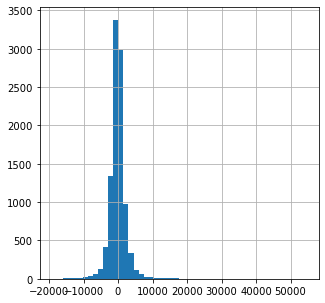

In [25]:
# Plot resiudals as a sanity check
gb_resid_50 = y_test - test_preds
gb_resid_50.hist(bins=50, figsize=(5,5));

## XGBRegressor()

Extreme Gradient Boosting is just an extension on the Gradient Boosting method. The main selling point of XGB over GB is that it uses 2nd order partial derivatives of the loss function to provide further detail about the direction of gradient change and how to best minimise the loss function. It's a more flexible library which I honestly haven't been able to explore as thoroughly as I would like. I've included it here in the project but do not progress with it.

In [26]:
# Modelling with dummies - XGBOOST()) 

xgb = XGBRegressor()
pipexgb = Pipeline(steps=[('model',xgb)])
pipexgb.get_params()

params = {'model__n_estimators':[50,100,200],
          'model__max_depth':[3,5,8],
          'model__learning_rate':[0.05,0.1,0.2],
          'model__random_state':[1],
          'model__n_jobs':[3]}

gridsearchxgb = GridSearchCV(pipexgb, params, cv=5, verbose=1)
gridsearchxgb.fit(X_train, y_train)

# XGBOOST Model evaluation stats
train_preds = gridsearchxgb.predict(X_train)
test_preds = gridsearchxgb.predict(X_test)
printmd('**XGBOOSTING REGRESSOR**')
print('MSE train:',mean_squared_error(y_train, train_preds))
print('MSE test:',mean_squared_error(y_test, test_preds))
print('RMSE train:',np.sqrt(mean_squared_error(y_train, train_preds)))
print('RMSE test:',np.sqrt(mean_squared_error(y_test, test_preds)))
print('R2 train:',gridsearchxgb.score(X_train, y_train))
print('R2 test:',gridsearchxgb.score(X_test, y_test))
print('\n')
print(gridsearchxgb.best_estimator_)

# Save stats for summary later
xgbdict = {'Model': 'XGBOOST Regressor', 
          'MSE Train': mean_squared_error(y_train, train_preds),
          'MSE Test': mean_squared_error(y_test, test_preds),
          'RMSE Train': np.sqrt(mean_squared_error(y_train, train_preds)),
          'RMSE Test': np.sqrt(mean_squared_error(y_test, test_preds)),
          'R2 Train': gridsearchxgb.score(X_train, y_train),
          'R2 Test': gridsearchxgb.score(X_test, y_test),
          'Params': gridsearchxgb.best_estimator_
         }

Fitting 5 folds for each of 27 candidates, totalling 135 fits


**XGBOOSTING REGRESSOR**

MSE train: 2334269.727131584
MSE test: 6311041.859078783
RMSE train: 1527.8317077255545
RMSE test: 2512.17870763184
R2 train: 0.9836609538406016
R2 test: 0.9559161461007781


Pipeline(steps=[('model',
                 XGBRegressor(learning_rate=0.2, max_depth=8, n_estimators=200,
                              n_jobs=3, random_state=1))])


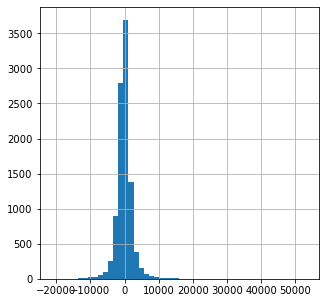

In [27]:
# Plot residuals as a sanity check
xgb_resid_50 = y_test - test_preds
xgb_resid_50.hist(bins=50, figsize=(5,5));

## Summary of models

Finally I can summarise all of these model scoring statistics in a neat table and plot the residual distributions in one place for comparison.

In [28]:
pd.DataFrame([lrdict,ladict,rrdict,eldict,dtdict,rfdict,gbdict,abdict,xgbdict])

,Model,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test,Params
0,Linear Regression,1.799921e+07,1.867039e+07,4242.547706,4320.924490,0.873156,0.872940,"(StandardScaler(), LinearRegression(n_jobs=2))"
1,Lasso (L1) Regression,1.796347e+07,1.862788e+07,4238.333672,4316.003278,0.873408,0.873229,"(StandardScaler(), Lasso(alpha=0.0001, max_ite..."
2,Ridge (L2) Regression,1.799572e+07,1.866746e+07,4242.135941,4320.585299,0.873181,0.872960,"(StandardScaler(), Ridge(alpha=5, max_iter=200))"
3,Elastic Net Regression,1.797596e+07,1.864484e+07,4239.807105,4317.967559,0.873320,0.873114,"(StandardScaler(), ElasticNet(alpha=0.0001, ra..."
4,Decision Tree Regressor,1.115931e+07,1.337089e+07,3340.555960,3656.622480,0.921889,0.906602,(DecisionTreeRegressor(criterion='friedman_mse...
5,Random Forrest Regressor,2.991235e+06,7.059899e+06,1729.518689,2657.047138,0.979062,0.950685,"((DecisionTreeRegressor(max_depth=15, max_feat..."
6,Gradient Boosting Regressor,3.169815e+06,6.437115e+06,1780.397556,2537.147098,0.977812,0.955035,(([DecisionTreeRegressor(criterion='friedman_m...
7,Ada Boosting Regressor,4.085893e+06,8.381160e+06,2021.359098,2895.023392,0.971400,0.941456,((DecisionTreeRegressor(criterion='friedman_ms...
8,XGBOOST Regressor,2.334270e+06,6.311042e+06,1527.831708,2512.178708,0.983661,0.955916,"(XGBRegressor(learning_rate=0.2, max_depth=8, ..."


We have lots of very good R<sup>2</sup> scores here - the price of a car must be well described by the predictors that were gathered from AutoTrader.

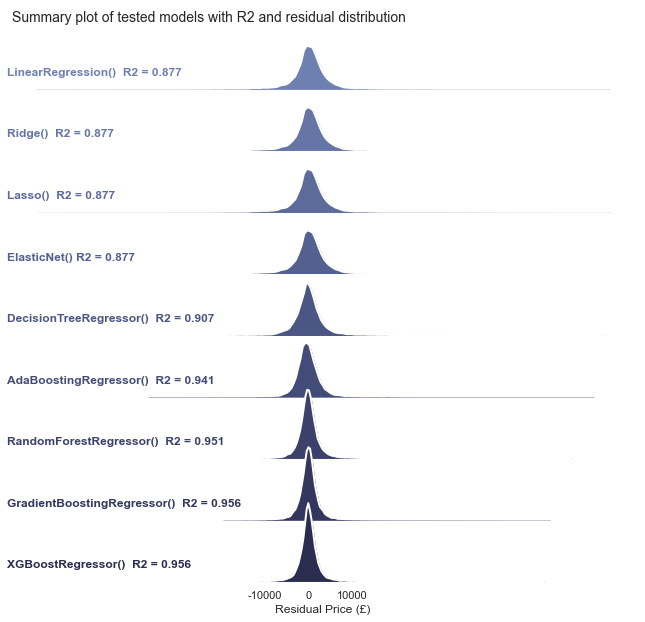

In [29]:
# Ambitious Residuals plot - needs work on X-axis

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Make the input data - really clumsy.
lr_resid50_df = pd.DataFrame(lr_resid_50)
lr_resid50_df['model']='LinearRegression()  R2 = 0.877'
lr_resid50_df.columns = ['price', 'model']
la_resid50_df = pd.DataFrame(la_resid_50)
la_resid50_df['model']='Ridge()  R2 = 0.877'
la_resid50_df.columns = ['price', 'model']
rr_resid50_df = pd.DataFrame(rr_resid_50)
rr_resid50_df['model']='Lasso()  R2 = 0.877'
rr_resid50_df.columns = ['price', 'model']
en_resid50_df = pd.DataFrame(en_resid_50)
en_resid50_df['model']='ElasticNet() R2 = 0.877'
en_resid50_df.columns = ['price', 'model']
dt_resid50_df = pd.DataFrame(dt_resid_50)
dt_resid50_df['model']='DecisionTreeRegressor()  R2 = 0.907'
rf_resid50_df = pd.DataFrame(rf_resid_50)
rf_resid50_df['model']='RandomForestRegressor()  R2 = 0.951'
gb_resid50_df = pd.DataFrame(gb_resid_50)
gb_resid50_df['model']='GradientBoostingRegressor()  R2 = 0.956'
ab_resid50_df = pd.DataFrame(ab_resid_50)
ab_resid50_df['model']='AdaBoostingRegressor()  R2 = 0.941'
xgb_resid50_df = pd.DataFrame(xgb_resid_50)
xgb_resid50_df['model']='XGBoostRegressor()  R2 = 0.956'

tocat=[lr_resid50_df,la_resid50_df,rr_resid50_df,en_resid50_df,dt_resid50_df,
       ab_resid50_df,rf_resid50_df,gb_resid50_df,xgb_resid50_df]
residplotdf = pd.concat(tocat)
residplotdf.columns = ['Residual Price (£)', 'model']

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.1, light=.5)
g = sns.FacetGrid(residplotdf, row="model", hue="model", aspect=10, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Residual Price (£)",
      bw_adjust=.5, clip_on=True,
      fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, "Residual Price (£)", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2,linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Residual Price (£)")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)
#setting xticks

ticks = [-10000, 0, 10000]
labels = [i for i in ticks]
g.set(xticks = ticks, xticklabels = labels)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.title('Summary plot of tested models with R2 and residual distribution',x=0.32, y=6.75, fontsize=14)
plt.savefig('modelsummary.pdf',bbox_inches='tight')
plt.show()

These models are ranked worst to best R<sup>2</sup> score from top to bottom. Here are some observations:

* Short and wide residual distributions are bad - these tell of a wide range of price prediction errors.
* Tall and narrow residual distributions are good - these tell of price prediction errors much closer to £0.
* Tree based methods are performing measurably better than the linear based methods here. This is likely because some of the linear regression assumptions were being violated.

I have chosen two models to take forwards for modelling on the full used car dataset rather than this 50,000 car subset. These will be the LinearRegression() model and the GradientBoostingRegressor() model. 

The LinearRegression() model has been chosen because of how interpretable the model outputs are. Remembering that interpretability was one of the primary project objectives.

The GradientBoostingRegressor() has been chosen because it performed best. Notice that this parameterisation also generalises very well, with minimal differences between test data scores and train data scores.

# Modeling on all used cars

Now I'm going to progress with a linear regression model and the gradient boosting regressor model from sklearn. The only difference will be that this time models are run on the full dataset, increasing the size of both the train and test datasets. 

## LinearRegression()

In [30]:
# Read clean used cars data, drop columns not useful in modelling and drop under populated makes

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
df = pd.read_csv(abspath)
print('all',df.shape)

# Save copy for reference later
refdf = df.copy()

# Select used cars only
df = df[df['used']==1]
print('used',df.shape)

# Drop outliers in log-price
mask = np.abs((df.log_price - df.log_price.mean())) / df.log_price.std() > 3
df= df[~mask]
print('used_without_outliers',df.shape)

# Drop outliers in log-mileage
mask = np.abs((df.log_mileage - df.log_mileage.mean())) / df.log_mileage.std() > 3
df= df[~mask]
print('used_without_mileage_outliers',df.shape)

# Drop outliers in BHP
mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
df= df[~mask]
print('used_without_BHP_outliers',df.shape)

# Drop columns not used in modelling
df = df.drop(labels=['name','name_subtitle','link','seller1',
                     'href0','dealer_city','dealer_area','year_reg',
                     'orig_name','e_engine_kWh','ULEZ','id','used',
                     'owners','engine','mpg'], axis=1)

print('used_without_extra_columns', df.shape)

# Drop under populated car brands
carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>200].make.to_list()
df = df[df.make.isin(carmakes)].copy()

print('used_without_little_makes', df.shape)

# carnumsyear = df.groupby(by='year')['price'].count().sort_values().reset_index()
# carsyearnum = carnumsyear[carnumsyear.price>100].year.to_list()
# df = df[df.year.isin(carsyearnum)].copy()

# print('used_without_little_years', df.shape)

all (400245, 28)
used (378595, 28)
used_without_outliers (374504, 28)
used_without_mileage_outliers (370686, 28)
used_without_BHP_outliers (370525, 28)
used_without_extra_columns (370525, 12)
used_without_little_makes (369730, 12)


In [31]:
df.columns

Index(['year', 'price', 'body', 'mileage', 'BHP', 'doors', 'transmission',
       'make', 'fuel', 'drivertrain', 'log_price', 'log_mileage'],
      dtype='object')

### LinearRegression() - Modelling

In [32]:
# Modelling with dummies - SKLEARN LinearRegression() 

# Select relevant data notice that log_price and log_mileage are used in this linear regression model
# for the same reasons described at the start of section 3 - Model selection. 
X = df[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]

# Pop target - log transformed for approximately normal distribution.
y = X.pop('log_price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
# Dummify necessary columns
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_trainlr, X_testlr, y_trainlr, y_testlr = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=42)

# Standard scaling implemented on predictors for the linear regression model
scaler = StandardScaler()
lr = LinearRegression()
pipelr = Pipeline(steps=[('scaler',scaler),('model',lr)])

# There are very few parameter options to search over for a simple linear regression!
params = {'model__copy_X': [True],
          'model__fit_intercept': [True],
          'model__n_jobs': [2],
          'model__normalize': [False],
          'model__positive': [False]}

gridsearchlr = GridSearchCV(pipelr, params, cv=5, verbose=1)
gridsearchlr.fit(X_trainlr, y_trainlr)


Dummified df shape (369730, 63) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LinearRegression())]),
             param_grid={'model__copy_X': [True],
                         'model__fit_intercept': [True], 'model__n_jobs': [2],
                         'model__normalize': [False],
                         'model__positive': [False]},
             verbose=1)

### LinearRegression() - Scoring

In [33]:
# LinearRegression Model evaluation stats
lrtrain_preds = gridsearchlr.predict(X_trainlr)
lrtest_preds = gridsearchlr.predict(X_testlr)
printmd('**LINEAR REGRESSION**')
# Logarithmic gymnastics done around here using NumPy to obtain scores in terms of price rather than log_price.
print('MSE train:',mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds)))
print('MSE test:',mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds)))))
print('R2 train on log_price:',gridsearchlr.score(X_trainlr, y_trainlr))
print('R2 test on log_price:',gridsearchlr.score(X_testlr, y_testlr))
print('R2 train on price:',r2_score(np.exp(y_trainlr), np.exp(lrtrain_preds)))
print('R2 test on price:',r2_score(np.exp(y_testlr), np.exp(lrtest_preds)))
print('\n')
print(gridsearchlr.best_estimator_)

# Save model evaluation scores
lrdict2 = {'Model': 'Linear Regression', 
          'MSE Train': mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds)),
          'MSE Test': mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds))),
          'R2 Train': r2_score(np.exp(y_trainlr), np.exp(lrtrain_preds)),
          'R2 Test': r2_score(np.exp(y_testlr), np.exp(lrtest_preds)),
          'Params': gridsearchlr.best_estimator_
         }

**LINEAR REGRESSION**

MSE train: 16729072.86025578
MSE test: 16612486.259465361
RMSE train: 4090.1189298424783
RMSE test: 4075.84178538193
R2 train on log_price: 0.9166323722289952
R2 test on log_price: 0.9178004802732642
R2 train on price: 0.8782356907449657
R2 test on price: 0.881480258729703


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearRegression(n_jobs=2))])


### LinearRegression() - Evaluation and Interpretation

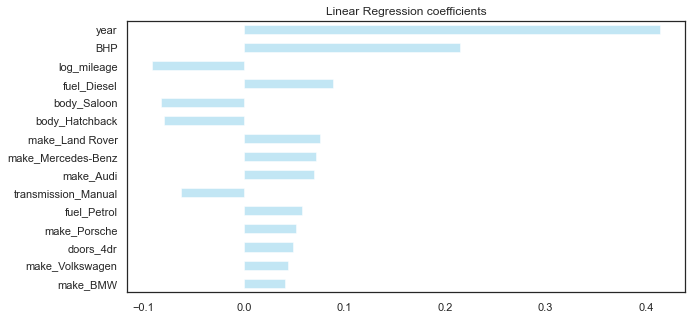

In [34]:
# Evaluate coefficients form linear regression and place them in a neat dataframe
lr_coefs = pd.DataFrame({'variable': X_trainlr.columns,
                            'coef': gridsearchlr.best_estimator_.named_steps['model'].coef_,
                            'abs_coef': np.abs(gridsearchlr.best_estimator_.named_steps['model'].coef_),
                            '1 std dev increase in variable causes X percent change on price':(np.exp(gridsearchlr.best_estimator_.named_steps['model'].coef_)-1)*100})
lr_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lr_coefs['Percentage increase in price for every 20% increase X'] = np.nan
lr_coefs.loc[0,'Percentage increase in price for every 20% increase X'] = ((1.20**(lr_coefs.loc[0,'coef'])-1)*100)
# https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/#:~:text=Interpret%20the%20coefficient%20as%20the,variable%20increases%20by%20about%200.20%25.

# Plot the beta coefficients
fig, ax = plt.subplots(figsize=(10, 5))
lr_coefs.coef[:15].plot(kind='barh', color = 'skyblue', ax=ax, alpha=0.5, title='Linear Regression coefficients')
ax.set_yticklabels(lr_coefs.variable[:15].values)
plt.gca().invert_yaxis()
plt.show()

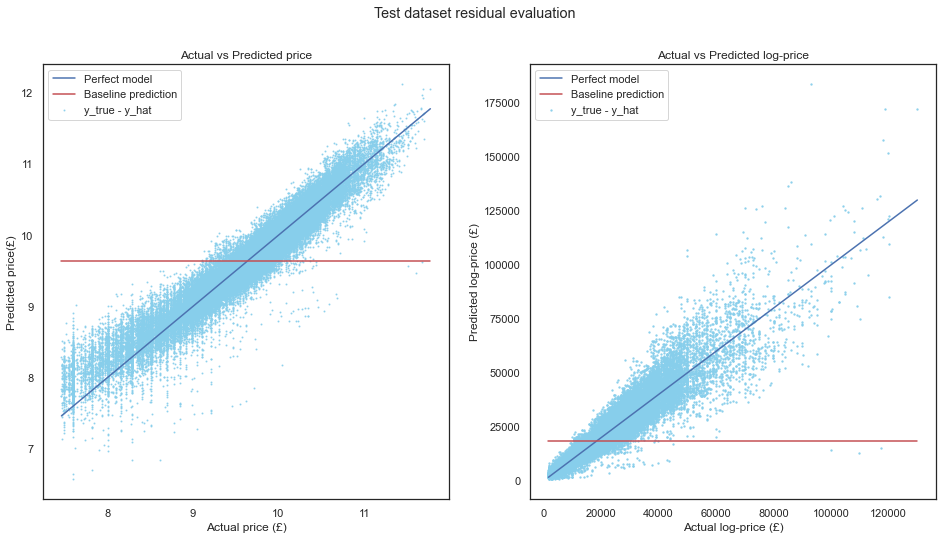

In [35]:
# Plot test predicted vs actual price in both log-space and non. 
fig, ax = plt.subplots(ncols=2,figsize=(16,8))
ax[0].scatter(y_testlr, lrtest_preds, color='skyblue', alpha=0.8, s=1, label = 'y_true - y_hat')
ax[0].plot([y_testlr.min(), y_testlr.max()], [y_testlr.min(), y_testlr.max()], c='b',label = 'Perfect model')
ax[0].set_title('Actual vs Predicted price')
ax[0].set_xlabel("Actual price (£)")
ax[0].set_ylabel("Predicted price(£)")
ax[0].plot([y_testlr.min(), y_testlr.max()], [y_testlr.mean(), y_testlr.mean()], c='r', label = 'Baseline prediction')
ax[1].scatter(np.exp(y_testlr), np.exp(lrtest_preds), color='skyblue', alpha=0.8, s=2,  label = 'y_true - y_hat')
ax[1].plot([np.exp(y_testlr).min(), np.exp(y_testlr).max()], [np.exp(y_testlr).min(), np.exp(y_testlr).max()], 
           c='b', label = 'Perfect model')
ax[1].set_title('Actual vs Predicted log-price')
ax[1].set_xlabel("Actual log-price (£)")
ax[1].set_ylabel("Predicted log-price (£)")
ax[1].plot([np.exp(y_testlr).min(), np.exp(y_testlr).max()], [np.exp(y_testlr).mean(), np.exp(y_testlr).mean()], 
           c='r', label = 'Baseline prediction')
ax[0].legend()
ax[1].legend()
plt.suptitle('Test dataset residual evaluation')
for i in range(2):
    legend = ax[i].legend()
    frame = legend.get_frame()
    frame.set_facecolor('white')
plt.show()

These two scatter plots above compare the predicted price to the actual price, both in terms of price and log_price. It can be seen from the right hand plot that the linear regression model yields better predictions for cheaper price cars, with errors generally growing with an increase in the used car price. This is a knock-on effect of predicting log_price rather than price.

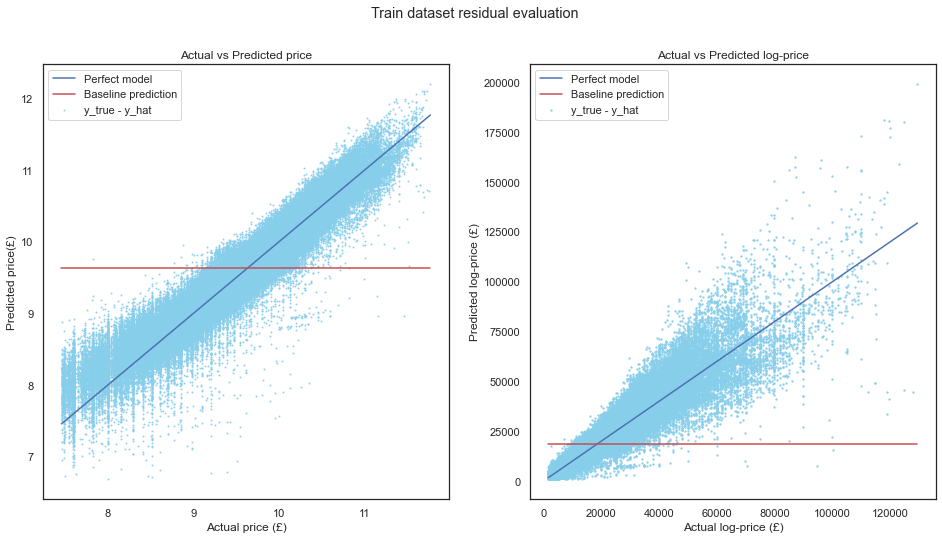

In [36]:
# Plot train predicted vs actual price in both log-space and non. 

fig, ax = plt.subplots(ncols=2,figsize=(16,8))
ax[0].scatter(y_trainlr, lrtrain_preds, color='skyblue', alpha=0.8, s=1, label = 'y_true - y_hat')
ax[0].plot([y_trainlr.min(), y_trainlr.max()], [y_trainlr.min(), y_trainlr.max()], c='b',label = 'Perfect model')
ax[0].set_title('Actual vs Predicted price')
ax[0].set_xlabel("Actual price (£)")
ax[0].set_ylabel("Predicted price(£)")
ax[0].plot([y_trainlr.min(), y_trainlr.max()], [y_trainlr.mean(), y_trainlr.mean()], c='r', label = 'Baseline prediction')
ax[1].scatter(np.exp(y_trainlr), np.exp(lrtrain_preds), color='skyblue', alpha=0.8, s=2,  label = 'y_true - y_hat')
ax[1].plot([np.exp(y_trainlr).min(), np.exp(y_trainlr).max()], [np.exp(y_trainlr).min(), np.exp(y_trainlr).max()], 
           c='b', label = 'Perfect model')
ax[1].set_title('Actual vs Predicted log-price')
ax[1].set_xlabel("Actual log-price (£)")
ax[1].set_ylabel("Predicted log-price (£)")
ax[1].plot([np.exp(y_trainlr).min(), np.exp(y_trainlr).max()], [np.exp(y_trainlr).mean(), np.exp(y_trainlr).mean()], 
           c='r', label = 'Baseline prediction')
ax[0].legend()
ax[1].legend()
for i in range(2):
    legend = ax[i].legend()
    frame = legend.get_frame()
    frame.set_facecolor('white')
plt.suptitle('Train dataset residual evaluation')
plt.show()

The train dataset tells the same story as the test dataset.

In [37]:
# Display table of coefficients and the translation of their impact on price
lr_coefs.sort_values(by='abs_coef', ascending=False).iloc[:,:-1].head(10)

,variable,coef,abs_coef,1 std dev increase in variable causes X percent change on price
1,year,0.413523,0.413523,51.213514
2,BHP,0.215040,0.215040,23.991109
0,log_mileage,-0.090919,0.090919,-8.690793
52,fuel_Diesel,0.088302,0.088302,9.231765
49,body_Saloon,-0.082759,0.082759,-7.942682
45,body_Hatchback,-0.079176,0.079176,-7.612243
20,make_Land Rover,0.075445,0.075445,7.836401
25,make_Mercedes-Benz,0.071659,0.071659,7.428905
6,make_Audi,0.070172,0.070172,7.269262
51,transmission_Manual,-0.062038,0.062038,-6.015321


Interpreting beta coefficients of the linear regression is complicated by the log transforms and standardisation implemented in modelling. I have followed the stages outlined [here](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/#:~:text=Interpret%20the%20coefficient%20as%20the,variable%20increases%20by%20about%200.20%25.
) to convert the coefficients to real terms that we might be able to handle. 

The table above should be interpreted as the title of the final column.
* An increase in the `year` predictor by one standard deviation would yield a 51.2% increase in car `price`. 
* An increase in the `log_mileage` predictor by one standard deviation would yield a 8.7% decrease in car `price`. 


Personally I don't find this easily intuitive without having all of the standard deviations of each original predictor to hand! I'm not going to dwell on this interpretation because I had much greater fun interrogating the gradient boosting regressor output, *and* the model performed better.

In [38]:
# Define top_lr_factors for later
top_lr_factors = lr_coefs.sort_values(by='abs_coef', ascending=False).head(10).variable.to_list()

## GradientBoostingRegressor()

*Why might I look to use a gradient boosting model?*

Where linear regression modelling started with a range of assumptions, gradient boosting methods only assume that the target variable is real-valued. This lack of assumptions can make it an appealing method for machine learning. 

Gradient boosting is a tree based ensemble technique in which the predictors are not made independently, but sequentially. The sequential method works in a way which allows subsequent predictors to learn from mistakes of their previous predictors.

<br>
<br>
<b>Gradient boosting explained</b>

* Gradient boosting starts with a base prediction by adopting the average value for the target variable before generating sequential predictors which aim to minimise the residuals between the base prediction and the actual values. 
* Each sequential predictor is scaled by a 'learning factor' before being added to the ensemble. This is usually some small fraction like 0.1 which forces the gradient boosting ensemble model to iteratively take small steps towards a better model with minimised residuals. 
* Taking many small steps in the right direction results in better predictions with a testing dataset. i.e. lower variance. 
* The model is considered optimised when adding new scaled predictors to the ensemble fails to reduce the residuals.



### GradientBoostingRegressor() - Modelling

In [39]:
# Modelling with dummies - SKLEARN GradientBoostingRegressor()) 

# Select relevant data notice that price and log_mileage are used in this gradient boosting model. I really could
# have used mileage instead of log_mileage but honestly I just forgot. I remembered to swap the target from 
# log_price to price but forgot to swap mileage. It makes no difference to to the gradient boosting model so I 
# opted to leave it as it is and compensate in any evaluation if/where required.
X = df[['price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
# Pop the target variable - price this time since it's a tree method
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
# Dummify the necessary columns
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_traingb, X_testgb, y_traingb, y_testgb = train_test_split(X,y,test_size=0.2, shuffle=y, random_state =2)

# Standard scaling not required for tree methods
model = GradientBoostingRegressor()
pipegb = Pipeline(steps=[('model',model)])
pipegb.get_params()

params = {'model__n_estimators':[50, 100, 200],
          'model__max_depth':[3,5],
          'model__learning_rate':[0.05, 0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

# criterion{‘f
# params = {'model__n_estimators':[200],
#           'model__max_depth':[5],
#           'model__learning_rate':[0.1],
#           'model__random_state':[1],
#           'model__validation_fraction':[0.1],
#           'model__n_iter_no_change':[20]}riedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}


gridsearchgb = GridSearchCV(pipegb, params, cv=5, verbose=1)
gridsearchgb.fit(X_traingb, y_traingb)

Dummified df shape (369730, 63) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', GradientBoostingRegressor())]),
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [50, 100, 200],
                         'model__n_iter_no_change': [20],
                         'model__random_state': [1],
                         'model__validation_fraction': [0.1]},
             verbose=1)

### GradientBoostingRegressor() - Scoring

In [40]:
# Gradient Boosting Model evaluation scores
gbtrain_preds = gridsearchgb.predict(X_traingb)
gbtest_preds = gridsearchgb.predict(X_testgb)
printmd('**GRADIENT BOOSTING REGRESSOR**')
print('MSE train:',mean_squared_error(y_traingb, gbtrain_preds))
print('MSE test:',mean_squared_error(y_testgb, gbtest_preds))
print('RMSE train:',np.sqrt(mean_squared_error(y_traingb, gbtrain_preds)))
print('RMSE test:',np.sqrt(mean_squared_error(y_testgb, gbtest_preds)))
print('R2 train:',gridsearchgb.score(X_traingb, y_traingb))
print('R2 test:',gridsearchgb.score(X_testgb, y_testgb))
print('\n')
print(gridsearchgb.best_estimator_)

# Save model evaluation scores
gbdict2 = {'Model': 'Gradient Boosting Regressor', 
          'MSE Train': mean_squared_error(y_traingb, gbtrain_preds),
          'MSE Test': mean_squared_error(y_testgb, gbtest_preds), 
          'R2 Train': gridsearchgb.score(X_traingb, y_traingb),
          'R2 Test': gridsearchgb.score(X_testgb, y_testgb),
          'Params': gridsearchgb.best_estimator_
         }

**GRADIENT BOOSTING REGRESSOR**

MSE train: 6220079.23752757
MSE test: 6343789.371232913
RMSE train: 2494.0086682943925
RMSE test: 2518.6880257850344
R2 train: 0.9549072682744557
R2 test: 0.9540184637085746


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


0.954 R<sup>2</sup> on the test data and 0.955 R<sup>2</sup> on the train data is good. The model generalises well.

### GradientBoostingRegressor() - Evaluation and Interpretation

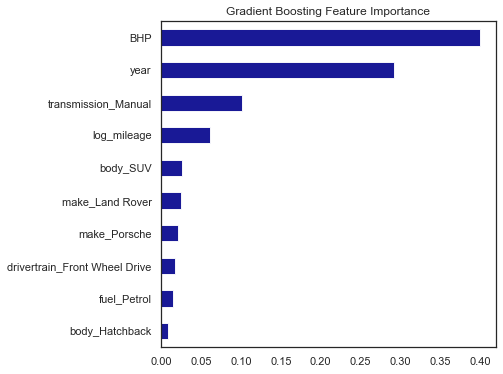

In [41]:
# Feature importance plot for gradient boosting 

# FROM SKLEARN
# feature_importances_
# The impurity-based feature importances.
# The higher, the more important the feature. The importance of a feature is computed as the 
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
# Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values)

# Make a dataframe of the feature importances
gb_coefs = pd.DataFrame({'variable': X_traingb.columns,
                            'Feature Importance': gridsearchgb.best_estimator_.named_steps["model"].feature_importances_})

# Plot them in descending importance
plot = gb_coefs.sort_values(by='Feature Importance', ascending=False).head(30)
fig, ax = plt.subplots(figsize=(6, 6))
plot['Feature Importance'][:10].plot(kind='barh', color = 'darkblue', ax=ax, alpha=0.9 )
ax.set_yticklabels(plot.variable[:10].values)
ax.set_title('Gradient Boosting Feature Importance', fontsize=12)
plt.gca().invert_yaxis()
plt.savefig('featimp.pdf',bbox_inches='tight')
plt.show()

The plot above describes feature importance from Sklearn

Decision tree methods can give us feature importances to illuminate what's happening under the hood. The higher the number the more important the predictor was for deciding splits at nodes. Technically, the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. In this case, the criterion is friedman_mse. 

That means a feature is more important...

- if it is used in many different nodes,
- if the difference in the measures of Gini or entropy are before and after the split is high

Feature importances are normalized in the sense of summing up to one.

In [42]:
# Compare top coefficients from LogisticRegression() against top feature importances from GradientBoostingRegressor()
top_gb_factors = gb_coefs.sort_values(by='Feature Importance', ascending=False).head(10).variable.to_list()

topfeaturedf = pd.DataFrame({'Top Linear Regression coefficients':top_lr_factors,'Top Gradient Boosting Feature Importances':top_gb_factors})
topfeaturedf

,Top Linear Regression coefficients,Top Gradient Boosting Feature Importances
0,year,BHP
1,BHP,year
2,log_mileage,transmission_Manual
3,fuel_Diesel,log_mileage
4,body_Saloon,body_SUV
5,body_Hatchback,make_Land Rover
6,make_Land Rover,make_Porsche
7,make_Mercedes-Benz,drivertrain_Front Wheel Drive
8,make_Audi,fuel_Petrol
9,transmission_Manual,body_Hatchback


Comparing top features from both models shows that they share 6 out of 10 of them. So similar, but not the same.

`year`,`BHP`,`log_mileage`,`transmission_Manual`, `make_Land Rover` and `body_Hatchback` are the predictors in common.

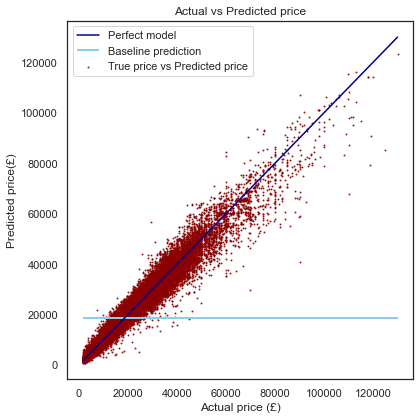

In [43]:
# Plot test actual vs predicted price 
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([y_testgb.min(), y_testgb.max()], [y_testgb.min(), y_testgb.max()], c='darkblue',label = 'Perfect model')
ax.set_title('Actual vs Predicted price',fontsize=12)
ax.set_xlabel("Actual price (£)", fontsize=12)
ax.set_ylabel("Predicted price(£)", fontsize=12)
plt.hlines(y=y_testgb.mean(), xmin=y_testgb.min(), xmax=y_testgb.max(), linewidth=2, color='skyblue', label = 'Baseline prediction')
ax.scatter(y_testgb, gbtest_preds, color='darkred', alpha=0.8, s=1, label = 'True price vs Predicted price')
plt.tight_layout()
plt.legend()
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig('actpred.pdf',bbox_inches='tight')
plt.show()

The plot of true price verses predicted price displays a tighter scattering of predictions than the linear regression model! It could still be said to have reduced performance above £80,000 but that would be being critical.

In [44]:
# Evaluate the biggest residuals. This short piece of code looks at the largest 3 prediction errors and prints
# out the corresponding vehicle attributes. Over time a lot of these links at the bottom are being removed as the 
# car sells. How disappointing.
resid = np.abs(y_testgb - gbtest_preds)
resid.sort_values(ascending=False)

sorted_resid = resid.sort_values(ascending=False).reset_index()
investigate1 = sorted_resid.iloc[0,0]
investigate2 = sorted_resid.iloc[1,0]
investigate3 = sorted_resid.iloc[2,0]

In [45]:
refdf.columns

Index(['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'dealer_area', 'dealer_city', 'seller1', 'used',
       'e_engine_kWh', 'log_price', 'log_mileage', 'orig_name', 'id',
       'year_reg', 'link', 'href0'],
      dtype='object')

In [46]:
# Print structured report of largest residual cars 

count=0
for residual in [investigate1,investigate2,investigate3]:
    count+=1
    printmd(f'**Bad prediction {count}**')
    print(refdf.loc[residual,'orig_name'],'\t', refdf.loc[residual,'name_subtitle'])
    print('Predicted price (£) \t',round(gridsearchgb.predict(X_testgb.loc[residual,:].array.reshape(1, -1))[0],2))
    print('Actual price (£)\t',refdf.loc[residual,'price'])
    print('City: \t\t\t',refdf.loc[residual,'dealer_city'])
    print(refdf.loc[residual,'link'])
    print('-'*65)

**Bad prediction 1**

Mercedes-Benz V Class 	 2.2 V250d AMG Line G-Tronic+ LWB EU6 (s/s) 5dr 8 Seat LWB
Predicted price (£) 	 40744.95
Actual price (£)	 89995.0
City: 			 woodford green
https://www.autotrader.co.uk/car-details/202112220751661
-----------------------------------------------------------------


**Bad prediction 2**

Land Rover Range Rover 	 2.0 P400e 12.4kWh Autobiography Auto 4WD (s/s) 5dr LWB
Predicted price (£) 	 67776.51
Actual price (£)	 109995.0
City: 			 welwyn garden city
https://www.autotrader.co.uk/car-details/202201201558506
-----------------------------------------------------------------


**Bad prediction 3**

BMW Z4 	 2.0 Z4 SDRIVE30I M SPORT 2d 255 BHP
Predicted price (£) 	 29747.56
Actual price (£)	 69995.0
City: 			 cleckheaton
https://www.autotrader.co.uk/car-details/202201181500668
-----------------------------------------------------------------


OK, so we have a well performing gradient boosting regressor model, but what can we do to make it more interpretable?

I have already displayed the feature importances (sometimes call gini-importances) from Scikit-learn, but these don't particularly illuminate why the model is predicting what it's predicting. As I noted before, it's more of an indication of why predictors were most helpful in making making the predictions. 

Now I'm going to use permutation importance from the ELI5 library to understand the model better.

In [47]:
# Use permutation importance from ELI5 package to obtain a weight to assign to each predictor
perm = PermutationImportance(gridsearchgb).fit(X_testgb, y_testgb)

In [48]:
# Feature importance from PermutationImportance package

# https://stats.stackexchange.com/questions/555949/how-to-interpret-the-feature-importances-for-eli5-show-weights-for-regressio
# For a high level overview of how the produced model works, we look at the weights from PermutationImportance
# I show the top 63 - That's them all. The eli5.show_weights function outputs a HTML table
eli5.show_weights(perm, feature_names = X_testgb.columns.values, top= 63)

Weight,Feature
0.4586 ± 0.0039,BHP
0.3560 ± 0.0019,year
0.0977 ± 0.0016,log_mileage
0.0328 ± 0.0008,make_Land Rover
0.0289 ± 0.0010,make_Porsche
0.0284 ± 0.0003,body_SUV
0.0282 ± 0.0005,transmission_Manual
0.0137 ± 0.0001,make_Mercedes-Benz
0.0132 ± 0.0007,fuel_Petrol
0.0125 ± 0.0006,make_Audi


In [49]:
# Zip together top coefficients for best LR model and best GB model using FI&PI
top_gb_factors_pi = pd.DataFrame((zip(X_testgb.columns.tolist(), perm.feature_importances_)), columns= ['variable','fi']).sort_values(by='fi', ascending=False).head(10).variable.to_list()
top_gb_factors = gb_coefs.sort_values(by='Feature Importance', ascending=False).head(10).variable.to_list()


featurecomp = pd.DataFrame({'rank':range(1,11),'LinearRegression top coefficients':top_lr_factors,'GradientBoostingRegression top features':top_gb_factors, 'GradientBoostingRegression top features from permutation importance':top_gb_factors_pi})
featurecomp.set_index('rank', drop=True, inplace=True)
featurecomp

,LinearRegression top coefficients,GradientBoostingRegression top features,GradientBoostingRegression top features from permutation importance
rank,,,
1,year,BHP,BHP
2,BHP,year,year
3,log_mileage,transmission_Manual,log_mileage
4,fuel_Diesel,log_mileage,make_Land Rover
5,body_Saloon,body_SUV,make_Porsche
6,body_Hatchback,make_Land Rover,body_SUV
7,make_Land Rover,make_Porsche,transmission_Manual
8,make_Mercedes-Benz,drivertrain_Front Wheel Drive,make_Mercedes-Benz
9,make_Audi,fuel_Petrol,fuel_Petrol


Linear regression coefficients and Gradient boosting feature importance have 6 common predictors in their top 10.

- `year`, `BHP`, `body_Hatchback`, `make_Land_Rover`, `transmission_Manual` and `log_mileage` 

Linear regression coefficients and Gradient boosting feature importance from permutation importance have 6 common predictors in their top 10.

- `year`, `BHP`, `make_Mercedez-Benz`, `make_Land_Rover`, `transmission_Manual` and `log_mileage` 


Gradient boosting feature importance and Gradient boosting feature importance from permutation importance have 8 common predictors in their top 10.

- `year`, `BHP`, `body_SUV`, `make_Porsche`, `make_Land_Rover`, `transmission_Manual`, `fuel_petrol` and `log_mileage` 


In [50]:
# Have a quick look at the feature importance and standard deviation from permutation importance 
df_fi = pd.DataFrame(dict(feature_names=X_testgb.columns.tolist(),
                          feat_imp=perm.feature_importances_, 
                          std=perm.feature_importances_std_,
                          ))
df_fi = df_fi.round(4)
df_fi.sort_values('feat_imp', ascending=False)

,feature_names,feat_imp,std
2,BHP,0.4586,0.0020
1,year,0.3560,0.0009
0,log_mileage,0.0977,0.0008
20,make_Land Rover,0.0328,0.0004
29,make_Porsche,0.0289,0.0005
...,...,...,...
14,make_Honda,0.0000,0.0000
36,make_Subaru,0.0000,0.0000
24,make_Mazda,0.0000,0.0000
33,make_Saab,0.0000,0.0000


In [51]:
# Look at feature importances for a individual car. This is the granular breakdown of why it costs what it costs.

# For a look at how a single car has been processed by the model, I can use the eli5.show_prediction utility.
# It takes the model as input, and a sample row, in this case I use row 5 from X_test and return the top 10 features
show_prediction(gridsearchgb.best_estimator_.named_steps["model"], X_testgb.iloc[24, :], top =16, show_feature_values=True)

This breakdown is wonderful but not exactly what I want. Notice that this car has the following price impacts for each of the dummified body features:
* It is not a Hatchback: +495
* It is not a MPV: -82
* It is not a Coupe: -127
* It is a Saloon: -297
* It is not a SUV: -532


This is not an exhaustive list, there will be other contributions for each option. Each categorical predictor, like the body example here, could be be collated to one figure. I'm going to write some functions to do just this. 

In [52]:
# Define functions for ELI5 car analysis 
# Having looked over these functions again since completing the project I can see many ways that I'd like
# to improve them. I'd love to remove the repritive code and make them far more concise, but I also want to 
# publish this project and move onto a new project in a different area. I'm going to leave them as they are.
# with this semi-guilty note attached!

def make_groupby_col(feature):
    """This function is used to help make an informative table in the generate_summary function output
    """
    if 'BHP' in feature:
        return 'BHP'
    if 'BIAS' in feature:
        return 'BIAS'
    if 'year' in feature:
        return 'year'
    if 'transmission' in feature:
        return 'transmission'
    if 'body' in feature:
        return 'body'
    if 'drivertrain' in feature:
        return 'drivertrain'
    if 'mpg' in feature:
        return 'mpg'
    if 'make' in feature:
        return 'make'
    if 'doors' in feature:
        return 'doors'
    if 'fuel' in feature:
        return 'fuel'
    if 'mileage' in feature:
        return 'mileage'
    
def generate_summary(model, car_details, verbose=False):
    """
    This function uses the eli5.explain_prediction_df to obtain a dataframe of weights
    and contributions for each row.
    """
    # Print summarised details of the car
    spiel = str(refdf.loc[pd.DataFrame(car_details).columns[0],'orig_name']+' '+refdf.loc[pd.DataFrame(car_details).columns[0],'name_subtitle'])
    printmd(f'**Car Summary:  {spiel}**')
    # Print out extensive details of the original car IF verbose == True
    if verbose==True:
        print('Original car')
        print(df.loc[pd.DataFrame(car_details).columns[0],:])
        print('\n')
    # Print out the predicted car price and the true car price. This involves a call to the model.
    print('Predicted price \t\t True price')
    print('£', round(gridsearchgb.best_estimator_.named_steps["model"].predict(pd.DataFrame(car_details).T)[0],2), \
          '\t\t\t £',df.loc[pd.DataFrame(car_details).columns[0],:][1],'\n')
    print(refdf.loc[pd.DataFrame(car_details).columns[0],'link'])

    # Use ELI5, the model and the input car to get price contributions for each of the predictors.
    eli5df = eli5.explain_prediction_df(estimator=model, doc=car_details)    
    # Define absolute weight for sorting purposes
    eli5df['absweight']=eli5df.weight.apply(lambda x: np.abs(x))
    # Call function to help define how to group the dummified predictors
    eli5df['Predictor']=eli5df.feature.apply(lambda x: make_groupby_col(x))
    # Groupby the new Predictor column and sort by absolute weight, descending. 
    eli5df = eli5df.groupby(by='Predictor').sum().sort_values(by='absweight', ascending=False)
    # Create a price column which cumulatively sums the price contributions. 
    eli5df['price']=eli5df.weight.cumsum()
    # Initialise an empty attribute column to be filled in next.
    eli5df['attribute']=0

    # Add the cars original attributes to the summary dataframe which is being created, using a loc lookup.
    for att in ['transmission','body','mileage','BHP','make','year','drivertrain','doors','fuel']:
        eli5df.loc[att,'attribute']=df.loc[pd.DataFrame(car_details).columns[0],att]
    eli5df.columns =['Price Contribution (£)','value','absweight','Cumulative Car Price (£)','Attribute']
    # Return summary dataframe
    return eli5df[['Attribute','Price Contribution (£)','Cumulative Car Price (£)']]

def make_and_predict_describe_fake_car(year = 2018,
                              mileage = 40000,
                              BHP = 120,
                              body = 'Hatchback', 
                              transmission = 'Manual', 
                              make = 'Ford', 
                              drivetrain = 'Front Wheel Drive',
                              drs = '5dr', 
                              fuel = 'Petrol',
                              model = gridsearchgb.best_estimator_.named_steps["model"]):
    """
    This function is used to generate fake cars based on user defined attributes and then predict the price
    AND return a price breakdown for those cars when pushed into the given model.
    """
    # Take a sample car from the test dataset to get the structure I want
    sample = pd.DataFrame(X_testgb.iloc[20, :]).T
    # Initialise empty holding lists
    makes=[]
    bodys=[]
    drivertrains=[]
    fuels=[]
    doors=[]
    transmissions=[]
    
    # For each dummified categorical variable in the sample car, append them to the appropriate holding list
    for x in sample.columns:
        if 'make' in x:
            makes.append(x)
        if 'body' in x:
            bodys.append(x)
        if 'drivertrain' in x:
            drivertrains.append(x)
        if 'fuel' in x:
            fuels.append(x)
        if 'door' in x:
            doors.append(x)
        if 'transmission' in x:
            transmissions.append(x)

    # Use list addition to compile a list of all columns        
    dummy_cols = [makes + bodys + drivertrains + fuels + doors + transmissions + ['log_mileage','year','BHP']]
    # Set all attributes in the car sample to zero.
    for x in dummy_cols:
        sample.loc[:,x]=0

    # Now begin to overwrite the blank samples with the associated entered parameters in the function.
    sample['year'] = year
    sample['BHP'] = BHP
    sample['log_mileage'] = np.log(mileage)
    sample[f'body_{body}'] = 1
    # Got to be careful with transmission because there are only 2 of them. 
    if transmission == 'Manual':
        sample[f'transmission_Manual'] = 1
    else:
        sample[f'transmission_Manual'] = 0
    sample[f'make_{make}'] = 1
    sample[f'drivertrain_{drivetrain}'] = 1
    sample[f'fuel_{fuel}'] = 1
    sample[f'doors_{drs}'] = 1

    # Begin the summary printout
    # Print the car model and associated predicted price
    printmd(f'**Car Summary for synthetic {make}**')
    print('£', round(gridsearchgb.best_estimator_.named_steps["model"].predict(sample.iloc[0,:].array.reshape(1, -1))[0],2))
    # Use ELI5, the model and the input car to get price contributions for each of the predictors.
    eli5df = eli5.explain_prediction_df(estimator=model, doc=sample.iloc[0,:])    
    # Define absolute weight for sorting purposes
    eli5df['absweight']=eli5df.weight.apply(lambda x: np.abs(x))
    # Call function to help define how to group the dummified predictors  
    eli5df['Predictor']=eli5df.feature.apply(lambda x: make_groupby_col(x))
    # Groupby the new Predictor column and sort by absolute weight, descending. 
    eli5df = eli5df.groupby(by='Predictor').sum().sort_values(by='absweight', ascending=False)
    # Create a price column which cumulatively sums the price contributions. 
    eli5df['price']=eli5df.weight.cumsum()
    # Initialise an empty attribute column to be filled in next.
    eli5df['attribute'] = 0

    # Populate attributes with the fake parameters entered to this function  
    eli5df.loc['BHP','attribute'] = BHP
    eli5df.loc['year','attribute'] = year
    eli5df.loc['mileage','attribute'] = mileage
    eli5df.loc['transmission','attribute'] = transmission
    eli5df.loc['make','attribute'] = make
    eli5df.loc['drivertrain','attribute'] = drivetrain
    eli5df.loc['doors','attribute'] = drs
    eli5df.loc['fuel','attribute'] = fuel  
    eli5df.loc['body','attribute'] = body 
    eli5df.columns=['Price contribution (£)','Attribute Into Model','Absolute Price Contribution','Cumulative Car Price (£)','Attribute']        
    # Return summary dataframe for the fake car
    return eli5df[['Attribute','Price contribution (£)','Cumulative Car Price (£)']        ]

def make_and_predict_fake_car(year = 2018,
                              mileage = 40000,
                              BHP = 120,
                              body = 'Hatchback', 
                              transmission = 'Manual', 
                              make = 'Ford', 
                              drivetrain = 'Front Wheel Drive',
                              drs = '5dr', 
                              fuel = 'Petrol',
                              model = gridsearchgb.best_estimator_.named_steps["model"]):
    """
    This function is used to generate fake cars based on user defined attributes and then predict the price
    for those cars when pushed into the given model.
    """
    # Take a sample car from the test dataset to get the structure I want
    sample = pd.DataFrame(X_testgb.iloc[20, :]).T
    # Initialise empty holding lists
    makes=[]
    bodys=[]
    drivertrains=[]
    fuels=[]
    doors=[]
    transmissions=[]

    # For each dummified categorical variable in the sample car, append them to the appropriate holding list  
    for x in sample.columns:
        if 'make' in x:
            makes.append(x)
        if 'body' in x:
            bodys.append(x)
        if 'drivertrain' in x:
            drivertrains.append(x)
        if 'fuel' in x:
            fuels.append(x)
        if 'door' in x:
            doors.append(x)
        if 'transmission' in x:
            transmissions.append(x)

    # Use list addition to compile a list of all columns        
    dummy_cols = [makes + bodys + drivertrains + fuels + doors + transmissions + ['log_mileage','year','BHP']]
    # Set all attributes in the car sample to zero.
    for x in dummy_cols:
        sample.loc[:,x]=0

    # Now begin to overwrite the blank samples with the associated entered parameters in the function.
    sample['year'] = year
    sample['BHP'] = BHP
    sample['log_mileage'] = np.log(mileage)
    sample[f'body_{body}'] = 1
    # Got to be careful with transmission because there are only 2 of them. 
    if transmission == 'Manual':
        sample[f'transmission_Manual'] = 1
    else:
        sample[f'transmission_Manual'] = 0
    sample[f'make_{make}'] = 1
    sample[f'drivertrain_{drivetrain}'] = 1
    sample[f'fuel_{fuel}'] = 1
    sample[f'doors_{drs}'] = 1
    
    # Return the predicted price for the fake car after entering it into the defined model. 
    return (round(gridsearchgb.best_estimator_.named_steps["model"].predict(sample.iloc[0,:].array.reshape(1, -1))[0],2))
    

I'm going to show how the `generate_summary` function can work to illuminate exactly what this model is doing 'under the hood'. Using ELI5 I have been able to gain a much better insight into why the model predicts what it does.

In [53]:
# Look at some car analysis for a random car
generate_summary(gridsearchgb.best_estimator_.named_steps["model"],X_testgb.iloc[24, :], verbose=False)

**Car Summary:  Mercedes-Benz Cla Class CLA 200 AMG Line 4dr Tip Auto 1.3**

Predicted price 		 True price
£ 28485.83 			 £ 29280.0 

https://www.autotrader.co.uk/car-details/202201211610830


,Attribute,Price Contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
year,2020,6820.560464,25447.465808
make,Mercedes-Benz,3066.388507,28513.854314
transmission,Automatic,2515.100300,31028.954614
body,Saloon,-585.262360,30443.692254
drivertrain,Front Wheel Drive,-976.292546,29467.399708
fuel,Petrol,-724.393900,28743.005808
BHP,160.749507,-331.921174,28411.084634
mileage,32524.0,73.202087,28484.286721


The `generate_summary` function has taken a car listing, returned the true and predicted price, and returned a value breakdown in dataframe format. 

This value breakdown obtained through some careful manipulation of the ELI5 permutation importance satisfies the [primary objective](#2-executive-summary). Great news.

I'm going to take this one step further and put it into a pretty plot which I can share in presentations for this project.

**Car Summary:  Mercedes-Benz Cla Class CLA 200 AMG Line 4dr Tip Auto 1.3**

Predicted price 		 True price
£ 28485.83 			 £ 29280.0 

https://www.autotrader.co.uk/car-details/202201211610830


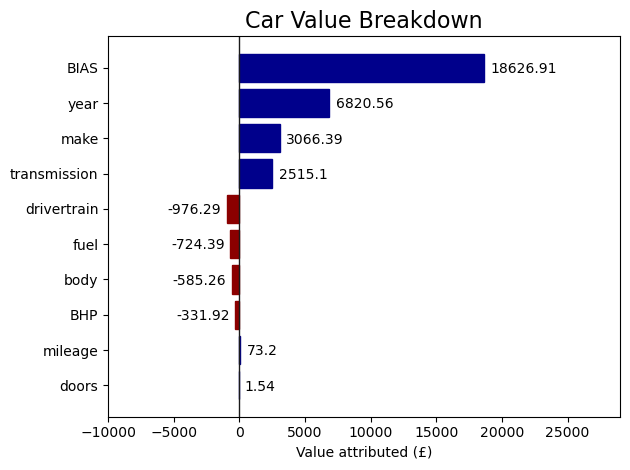

,Attribute,Price Contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
year,2020,6820.560464,25447.465808
make,Mercedes-Benz,3066.388507,28513.854314
transmission,Automatic,2515.100300,31028.954614
drivertrain,Front Wheel Drive,-976.292546,29467.399708
fuel,Petrol,-724.393900,28743.005808
body,Saloon,-585.262360,30443.692254
BHP,160.749507,-331.921174,28411.084634
mileage,32524.0,73.202087,28484.286721


In [54]:
# Plot the car value breakdown for this same Mercedes listing 

# Defining a simple function to return the desired colour of a bar in the coming bar chart depending on whether
# or not it's a positive or negative contributor.
def red_or_blue(x):
    if x>0:
        return 'darkblue'
    else:
        return 'darkred'

# Use henerate_summary to create breakdowndf
breakdowndf = generate_summary(gridsearchgb.best_estimator_.named_steps["model"],X_testgb.iloc[24, :], verbose=False)
# Create an absolute value of price contribution column to be used for sorting
breakdowndf['sort']=breakdowndf['Price Contribution (£)'].apply(lambda x: np.abs(x))
# Sort the values
breakdowndf = breakdowndf.sort_values(by='sort', ascending=False)
# Add a colour column to the breakdowndf, to make the plot pretty
breakdowndf['colour'] = breakdowndf['Price Contribution (£)'].apply(lambda x: red_or_blue(x))

# Plot the horizontal bar
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(breakdowndf.index, breakdowndf['Price Contribution (£)'], color='darkblue', edgecolor= 'white', linewidth=2000)
barlist = ax.barh(breakdowndf.index, breakdowndf['Price Contribution (£)'], color='darkblue')
# Set colour of the bar from the prepped breakdowndf.colour column
for i in range(0,10):
    barlist[i].set_color(breakdowndf.colour[i])
ax.set_xlim(-10000,29000)
ax.invert_yaxis()  
ax.set_xlabel('Value attributed (£)')
ax.set_title('Car Value Breakdown', fontsize=16)
ax.axvline(x=0,linewidth=1, color='k')
# This manually shifts the labels on each bar - it's not bery good because I have to eyeball it manyally for
# each plot. I'd like to improve this in future.
shift=[500,500,500,500,-4500,-4500,-4500,-4500,500,400]
for i, v in enumerate(round(breakdowndf['Price Contribution (£)'],2)):
    ax.text(v + shift[i], i + 00.15, str(v), color='black')
plt.tight_layout()
plt.show()

breakdowndf[['Attribute','Price Contribution (£)','Cumulative Car Price (£)']]

I'm really happy with this. £18627 is the average price of a car. This feature is constant in all value breakdowns, then from this point the remaining value discrepancy is attributed to the variability of remaining predictors within the dataset. 

I'll run the same `generate_summary` function for a different car below and the different car attributes return a new array of price contributions to arrive at the final predicted price.

**Car Summary:  MINI Countryman 1.5 Cooper 5dr**

Predicted price 		 True price
£ 19317.08 			 £ 17999.0 

https://www.autotrader.co.uk/car-details/202201271841369


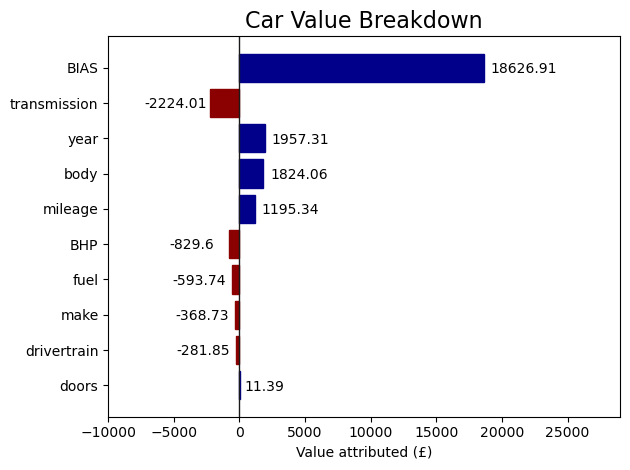

,Attribute,Price Contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
transmission,Manual,-2224.012905,16402.892439
year,2018,1957.307218,18360.199658
body,SUV,1824.056246,20184.255904
mileage,17654.0,1195.343945,21010.871819
BHP,136.0,-829.601714,20181.270105
fuel,Petrol,-593.740488,19587.529618
make,MINI,-368.728029,19815.527874
drivertrain,Front Wheel Drive,-281.845240,19305.684377


In [55]:
# Plot the car value breakdown for a sample car, row 40 from the test dataframe.

# Use henerate_summary to create breakdowndf
breakdowndf = generate_summary(gridsearchgb.best_estimator_.named_steps["model"],X_testgb.iloc[40, :], verbose=False)
# Create an absolute value of price contribution column to be used for sorting
breakdowndf['sort']=breakdowndf['Price Contribution (£)'].apply(lambda x: np.abs(x))
# Sort the values
breakdowndf = breakdowndf.sort_values(by='sort', ascending=False)
# Add a colour column to the breakdowndf, to make the plot pretty
breakdowndf['colour'] = breakdowndf['Price Contribution (£)'].apply(lambda x: red_or_blue(x))

# Plot the horizontal bar
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(breakdowndf.index, breakdowndf['Price Contribution (£)'], color='darkblue', edgecolor= 'white', linewidth=2000)
barlist = ax.barh(breakdowndf.index, breakdowndf['Price Contribution (£)'], color='darkblue')
# Set colour of the bar from the prepped breakdowndf.colour column
for i in range(0,10):
    barlist[i].set_color(breakdowndf.colour[i])
ax.set_xlim(-10000,29000)
ax.invert_yaxis()  
ax.set_xlabel('Value attributed (£)')
ax.set_title('Car Value Breakdown', fontsize=16)
ax.axvline(x=0,linewidth=1, color='k')
# This manually shifts the labels on each bar - it's not bery good because I have to eyeball it manyally for
# each plot. I'd like to improve this in future.
shift=[500,-5000,500,500,500,-4500,-4500,-4500,-4500,400]
for i, v in enumerate(round(breakdowndf['Price Contribution (£)'],2)):
    ax.text(v + shift[i], i + 00.15, str(v), color='black')
plt.tight_layout()
plt.show()

breakdowndf[['Attribute','Price Contribution (£)','Cumulative Car Price (£)']]

**Obtaining a used car value breakdown like this is something that satisfies the primary project objective.** Furthermore, being able to obtain this sort of insight from the GradientboostingRegressor() makes much of the work done in [4.1 LinearRegression()](#4.1-linear-regression) redundant as the model performance score are inferior to the GradientBoostingRegressor().

Now that the primary objective has been satisfied, I'm going to use the `make_and_predict_fake_car` and the `make_and_predict_describe_fake_car` functions to test the hypothesis that:<br><br>
    *When all other car attributes are equal, a Dacia branded car is cheaper than a Volvo branded car.*

In [56]:
# Synthetic Dacia 2018, 30000miles, 120BHP

make_and_predict_describe_fake_car(year = 2018,
                      mileage = 30000,
                      BHP = 120,
                      body = 'Hatchback', 
                      transmission = 'Manual', 
                      make = 'Dacia', 
                      drivetrain = 'Front Wheel Drive',
                      drs = '5dr', 
                      fuel = 'Petrol')


**Car Summary for synthetic Dacia**

£ 11439.84


,Attribute,Price contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
BHP,120,-2897.928756,15728.976587
make,Dacia,-2255.076875,13473.899712
transmission,Manual,-2210.424939,11263.474774
year,2018,1797.435411,13060.910185
body,Hatchback,-988.920346,12071.989839
fuel,Petrol,-530.532354,11541.457485
drivertrain,Front Wheel Drive,-268.080828,11273.376657
mileage,30000,158.471587,11431.848244


In [57]:
# Synthetic Volvo 2018, 30000miles, 120BHP

make_and_predict_describe_fake_car(year = 2018,
                      mileage = 30000,
                      BHP = 120,
                      body = 'Hatchback', 
                      transmission = 'Manual', 
                      make = 'Volvo', 
                      drivetrain = 'Front Wheel Drive',
                      drs = '5dr', 
                      fuel = 'Petrol')

**Car Summary for synthetic Volvo**

£ 15134.79


,Attribute,Price contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
transmission,Manual,-2206.118262,16420.787081
year,2018,1996.212972,18417.000053
make,Volvo,282.372201,18699.372255
body,Hatchback,-1652.328567,17047.043688
BHP,120,-1325.824697,15721.218990
fuel,Petrol,-540.595450,15180.623540
drivertrain,Front Wheel Drive,-266.895083,14913.728457
mileage,30000,198.183320,15111.911777


There it is then, for a standard car with the parameters listed below, a Dacia would cost £11439.84 while a Volvo would cost £15134.79. 

**When all other car attributes are equal, a Dacia branded car is indeed cheaper than a Volvo branded car.**

`year = 2018`
`mileage = 30000`
`BHP = 120`
`body = Hatchback `
`transmission = Manual `
`make = Volvo `
`drivetrain = Front Wheel Drive`
`drs = 5dr `
`fuel = Petrol`

Through curiosity I'm going to take the hypothesis one step further and use the same method to try to obtain an ordered list of car brands in terms of brand price influence.

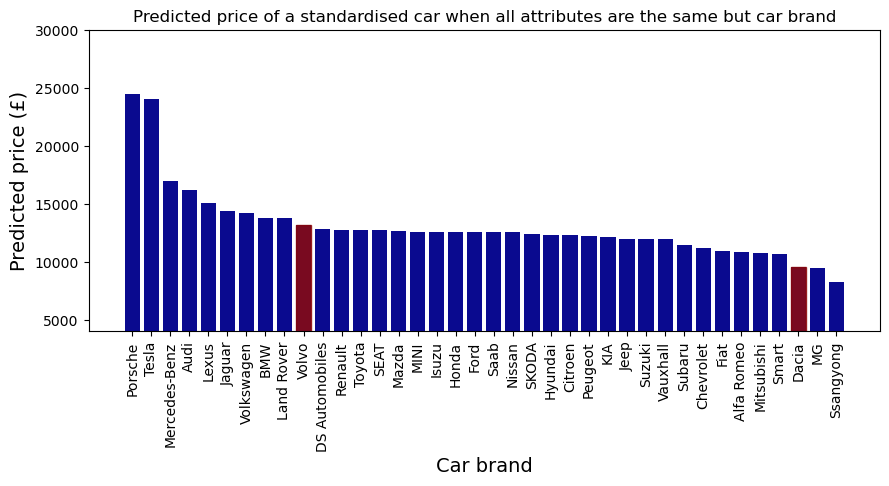

In [58]:
# Make dummy cars to test hypothesis and dummy car df 
options = ['Alfa Romeo','Audi','BMW','Chevrolet','Citroen','DS Automobiles','Dacia','Fiat',
           'Ford','Honda','Hyundai','Isuzu','Jaguar','Jeep','KIA','Land Rover','Lexus','MG',
           'MINI','Mazda','Mercedes-Benz','Mitsubishi','Nissan','Peugeot','Porsche','Renault',
           'SEAT','SKODA','Saab','Smart','Ssangyong','Subaru','Suzuki','Tesla','Toyota',
           'Vauxhall','Volkswagen','Volvo']  
equiv_cars = []
# For each of the makes in the list above, run the make_and_predict_fake_car function to obtain an equivalent price.
for make in options:
    equiv_cars.append(make_and_predict_fake_car(year = 2018, mileage = 30000, BHP = 100, make = make))

# Make this into a dataframe    
equiv_cars_df = pd.DataFrame({'Make':options,'Price (£)':equiv_cars})
# Sort the dataframe based on price
equiv_cars_df = equiv_cars_df.sort_values(by='Price (£)', ascending=False)


# Plot
fig, ax = plt.subplots(figsize=(9,4))
ax.bar(equiv_cars_df.Make, equiv_cars_df['Price (£)'], label = 'Predicted price for equivalent car', 
        width = 0.8, color = 'darkblue', alpha=0.8)
barlist = ax.bar(equiv_cars_df.Make, equiv_cars_df['Price (£)'], label = 'Predicted price for equivalent car', 
        width = 0.8, color = 'darkblue', alpha=0.8)
# I have manually labelled the Volvo and Dacia bars dark red, as I want to use this in a presentation later.
barlist[9].set_color('darkred')
barlist[-3].set_color('darkred')
ax.set_title('Predicted price of a standardised car when all attributes are the same but car brand',fontsize=12)
ax.set_xlabel("Car brand", fontsize=14)
ax.set_ylabel("Predicted price (£)", fontsize=14)
ax.set_ylim(4000,30000)
plt.tight_layout()
plt.xticks(equiv_cars_df.Make, rotation=90)
plt.savefig('fakecarbrand.pdf',bbox_inches='tight')
plt.show()

Ssangyong is the cheapest car brand and Porsche is the most expensive car brand.

It would be wise to note at this moment that if a car brand had fewer than 200 cars on the used car market at the time of this project then it was not included in modelling. As such the Lamborghini's and the Bugatti's are not included in this plot.

**With this, both the primary and secondary project objectives have been met. That would conclude the modelling stage of this project.**

Again, my curiosity got the better of me and I have been tempted to see what my model predicts will happen to the price of my own car over the coming years. I had to make an assumption that I drive 7000 miles a year, and the price forecast doesn't account for any sort of inflation or market conditions, but it's a bit of fun. Some price forecasts are included below. If you're interested the code could be adapted for any car of interest.

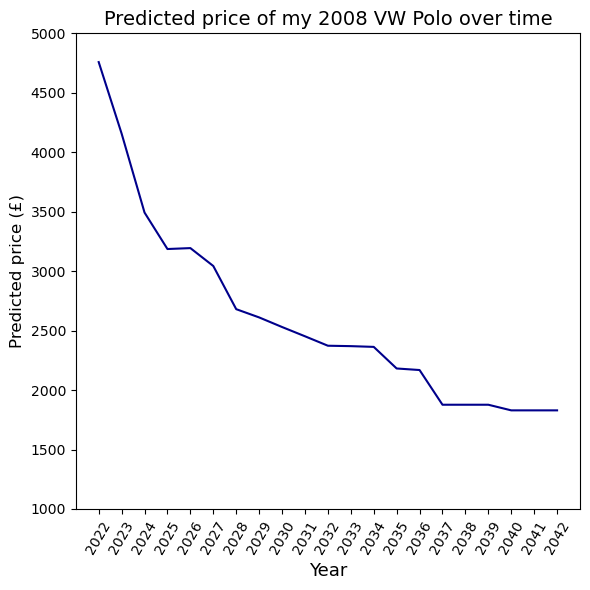

In [59]:
# Plot my polo depreciate over time. There are all sorts of things to think about when making future price 
# predictions and I don't intend to go into them here. I mention it in more detail in the project readme. 

polo_price = []
yr=2008
mil=40000
all_miles = []

# Loop through the make_and_predict_fake_car 21 times, incrementing the year and adding 7000 miles each year.
for i in range(0,21):
    polo_price.append(make_and_predict_fake_car(year = yr, 
                                                mileage = mil,
                                                BHP = 64,
                                                body = 'Hatchback', 
                                                transmission = 'Manual', 
                                                make = 'Volkswagen', 
                                                drivetrain = 'Front Wheel Drive',
                                                drs = '5dr', 
                                                fuel = 'Petrol'))
    all_miles.append(mil)
    yr-=1
    mil+=7000
    
polodf = pd.DataFrame({'Year': range(2022,2043), 'Price (£)':polo_price , 'Mileage': all_miles})

# Plot the results
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Predicted price of my 2008 VW Polo over time',fontsize=14)
ax.set_xlabel("Year", fontsize=13)
ax.set_ylabel("Predicted price (£)", fontsize=12)
ax.plot(polodf.Year, polodf['Price (£)'], c='darkblue',label = '2008 VW Polo Value')
plt.xticks(polodf.Year, rotation=60)
ax.set_ylim(1000,5000)
plt.tight_layout()
plt.show()

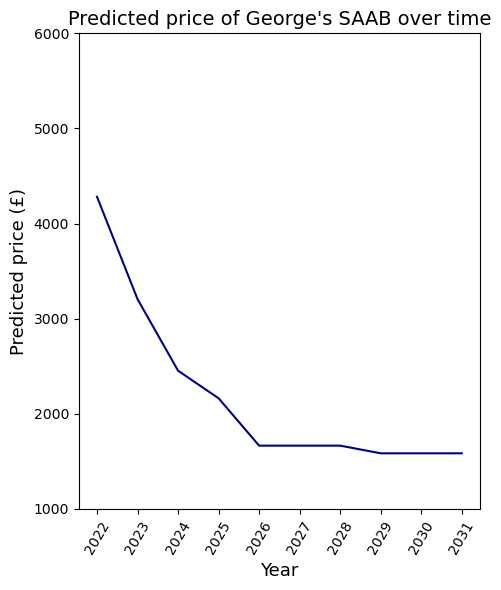

In [60]:
# Plot George's SAAB depreciate over time. This is just a bit of fun, I had a friend who was interested. 

saab_price = []
yr=2010
mil=117000
all_miles = []

# Loop through the make_and_predict_fake_car 10 times, incrementing the year and adding 7000 miles each year.
for i in range(0,10):
    saab_price.append(make_and_predict_fake_car(year = yr, 
                                                mileage = mil,
                                                BHP = 156,
                                                body = 'Saloon', 
                                                transmission = 'Automatic', 
                                                make = 'Saab', 
                                                drivetrain = 'Front Wheel Drive',
                                                drs = '5dr', 
                                                fuel = 'Diesel'))
    all_miles.append(mil)
    yr-=1
    mil+=7000
    
saabdf = pd.DataFrame({'Year': range(2022,2032), 'Price (£)':saab_price , 'Mileage': all_miles})

fig, ax = plt.subplots(figsize=(5,6))
ax.set_title("Predicted price of George's SAAB over time",fontsize=14)
ax.set_xlabel("Year", fontsize=13)
ax.set_ylabel("Predicted price (£)", fontsize=13)
ax.plot(saabdf.Year, saabdf['Price (£)'], c='darkblue',label = '2010 SAAB Value')
plt.xticks(saabdf.Year, rotation=60)
ax.set_ylim(1000,6000)
plt.tight_layout()
plt.show()

I don't think George was very happy with this forecast, but he shouldn't have bought a SAAB when they're already antiques.